In [ ]:
!pip install opencv-python numpy scikit-image matplotlib termcolor


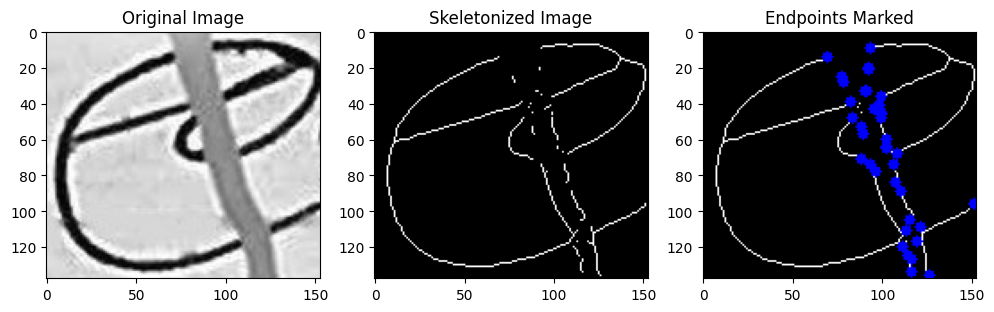

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert

# Function to detect endpoints in a skeletonized image
def detect_endpoints(skeleton):
    endpoints = []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 255:
                # Count neighboring white pixels
                neighbors = sum([skeleton[y + dy, x + dx] == 255
                                 for dy in [-1, 0, 1] for dx in [-1, 0, 1] if not (dx == 0 and dy == 0)])
                if neighbors == 1:  # Endpoint has only one neighbor
                    endpoints.append((x, y))
    return endpoints

# Load image in grayscale
image_path = "/content/minorSeg.jpeg"  # Change this to your file path
img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

# Convert to binary (invert colors for skeletonization)
_, binary = cv.threshold(img, 128, 255, cv.THRESH_BINARY_INV)

# Apply Skeletonization
skeleton = skeletonize(binary // 255) * 255  # Normalize back to 0-255

# Detect endpoints
endpoints = detect_endpoints(skeleton.astype(np.uint8))

# Convert skeleton to BGR for visualization
skeleton_bgr = cv.cvtColor(skeleton.astype(np.uint8), cv.COLOR_GRAY2BGR)

# Mark endpoints in red
for (x, y) in endpoints:
    cv.circle(skeleton_bgr, (x, y), 3, (0, 0, 255), -1)

# Save the marked image
    output_path = "marked.jpg"
    cv.imwrite(output_path, skeleton_bgr)

# Save the skelton image
output_path = "skelton.jpg"
cv.imwrite(output_path, skeleton)

# Plot images
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.title('Original Image')
plt.subplot(1, 3, 2), plt.imshow(skeleton, cmap='gray'), plt.title('Skeletonized Image')
plt.subplot(1, 3, 3), plt.imshow(skeleton_bgr), plt.title('Endpoints Marked')

plt.show()


Load the Image – Convert it to grayscale and apply binarization.
Preprocess the Image – Apply morphological operations to remove noise.
Skeletonization – Use skimage.morphology.skeletonize() to thin the letters.
Detect Endpoints – Identify valid endpoints of strokes.
Filter Out Unwanted Skeleton Pixels – Reduce artifacts from damage regions.
Display and Save the Results.

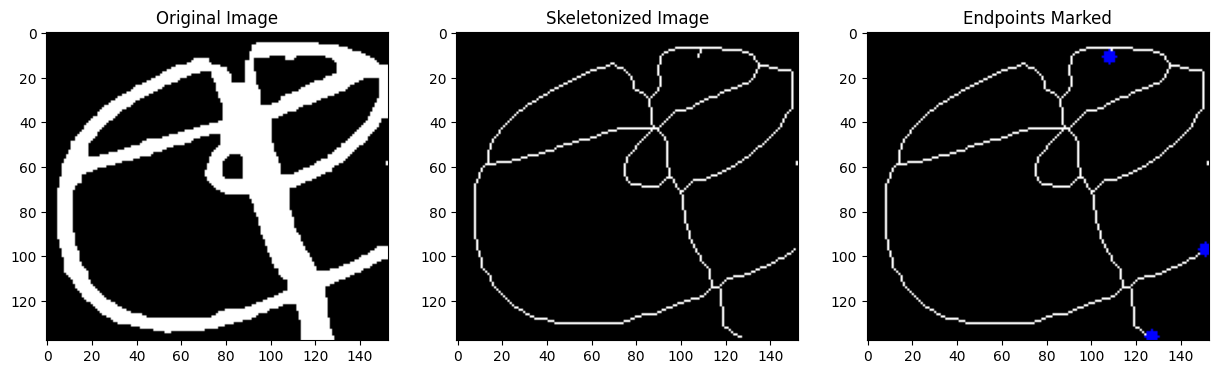

Image saved as: skeletonized_filtered.png


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.filters import threshold_otsu

# Function to load and preprocess the image
def preprocess_image(image_path):
    # Read image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not read image.")
        return None

    # Apply Otsu's Thresholding for binarization
    thresh_value = threshold_otsu(img)
    binary = (img > thresh_value).astype(np.uint8) * 255

    # Invert the image (text should be white, background black)
    binary = invert(binary)

    # Apply morphological closing to remove small holes and noise
    kernel = np.ones((3,3), np.uint8)
    processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    return processed

# Function to skeletonize the image
def skeletonize_image(binary):
    skeleton = skeletonize(binary / 255) * 255  # Normalize and skeletonize
    return skeleton.astype(np.uint8)

# Function to detect endpoints
def detect_endpoints(skeleton):
    endpoints = []
    rows, cols = skeleton.shape

    for y in range(1, rows - 1):
        for x in range(1, cols - 1):
            if skeleton[y, x] == 255:
                neighbors = [
                    skeleton[y-1, x-1], skeleton[y-1, x], skeleton[y-1, x+1],
                    skeleton[y, x-1],                          skeleton[y, x+1],
                    skeleton[y+1, x-1], skeleton[y+1, x], skeleton[y+1, x+1]
                ]
                count = np.sum(np.array(neighbors) == 255)

                if count == 1:  # Endpoint has only one neighbor
                    endpoints.append((x, y))

    return endpoints

# Function to plot the results
def plot_results(original, skeleton, endpoints):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")

    # Skeletonized Image
    plt.subplot(1, 3, 2)
    plt.imshow(skeleton, cmap='gray')
    plt.title("Skeletonized Image")

    # Endpoints Marked
    marked_image = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)
    for x, y in endpoints:
        cv2.circle(marked_image, (x, y), 3, (0, 0, 255), -1)  # Red dots for endpoints

    plt.subplot(1, 3, 3)
    plt.imshow(marked_image)
    plt.title("Endpoints Marked")

    plt.show()

# Function to save the skeletonized image
def save_image(image, filename):
    cv2.imwrite(filename, image)
    print(f"Image saved as: {filename}")

# Main Execution
image_path = "/content/minorSeg.jpeg"  # Change this to your uploaded image

binary_img = preprocess_image(image_path)
skeleton_img = skeletonize_image(binary_img)
endpoints = detect_endpoints(skeleton_img)

# Display results
plot_results(binary_img, skeleton_img, endpoints)

# Save skeletonized image
save_image(skeleton_img, "skeletonized_filtered.png")


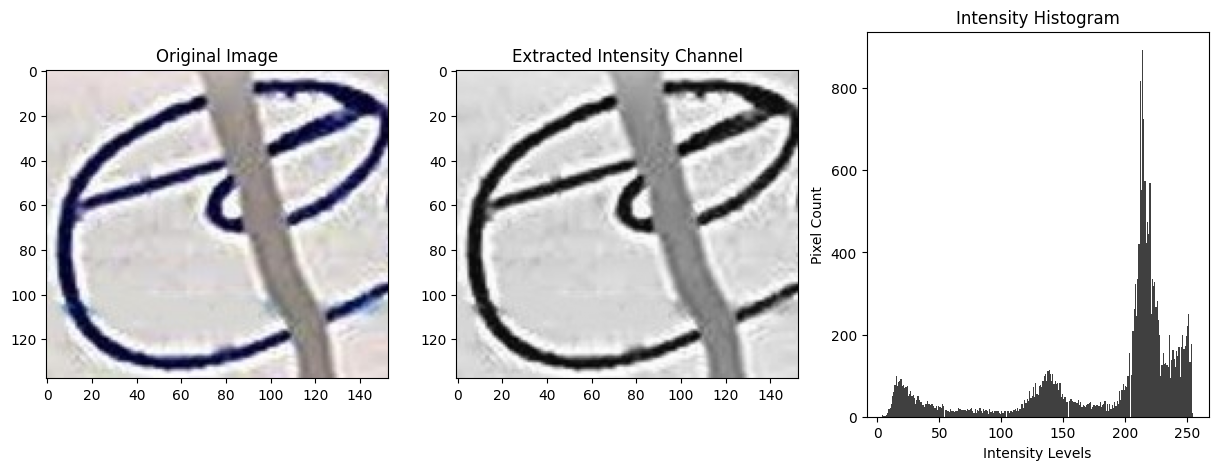

Intensity image saved as: intensity_mapped.png


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to convert RGB to HSI
def rgb_to_hsi(image):
    # Convert RGB to float and normalize
    img = image.astype(np.float32) / 255.0
    B, G, R = cv2.split(img)

    # Calculate Intensity
    I = (R + G + B) / 3

    # Calculate Saturation
    min_RGB = np.minimum(np.minimum(R, G), B)
    S = 1 - (3 / (R + G + B + 1e-6)) * min_RGB  # Avoid division by zero

    # Calculate Hue
    num = 0.5 * ((R - G) + (R - B))
    den = np.sqrt((R - G) ** 2 + (R - B) * (G - B) + 1e-6)  # Avoid division by zero
    theta = np.arccos(num / den)

    H = np.where(B > G, (2 * np.pi - theta), theta)
    H = H / (2 * np.pi)  # Normalize to [0,1]

    # Convert to 8-bit for display
    H = (H * 255).astype(np.uint8)
    S = (S * 255).astype(np.uint8)
    I = (I * 255).astype(np.uint8)

    return H, S, I

# Function to visualize and save intensity levels
def plot_intensity_mapping(image_path):
    # Load Image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Convert to HSI
    H, S, I = rgb_to_hsi(img)

    # Plot the images
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")

    # Intensity Image
    plt.subplot(1, 3, 2)
    plt.imshow(I, cmap='gray')
    plt.title("Extracted Intensity Channel")

    # Intensity Histogram
    plt.subplot(1, 3, 3)
    plt.hist(I.ravel(), bins=256, color='black', alpha=0.75)
    plt.title("Intensity Histogram")
    plt.xlabel("Intensity Levels")
    plt.ylabel("Pixel Count")

    plt.show()

    # Save intensity image
    cv2.imwrite("/content/intensity_mapped.png", I)
    print("Intensity image saved as: intensity_mapped.png")

# Run on Colab
image_path = "/content/minorSeg.jpeg"  # Change to your uploaded image
plot_intensity_mapping(image_path)


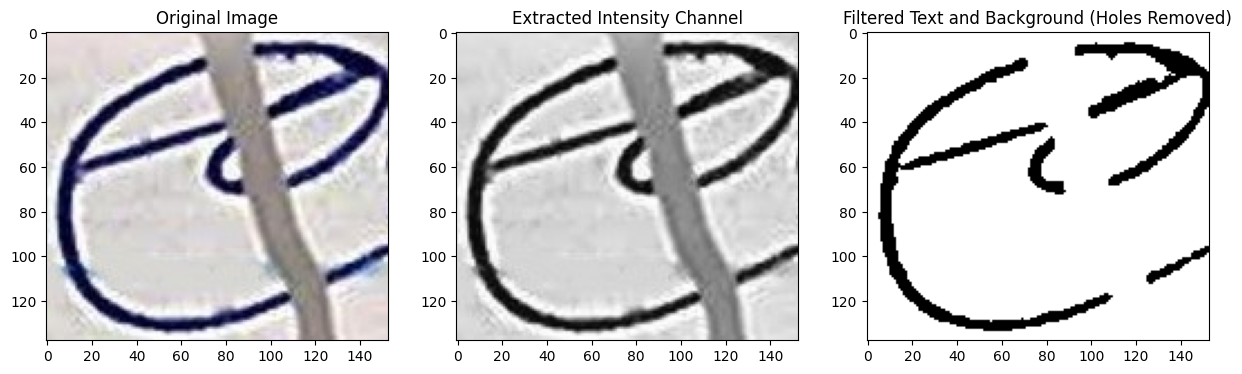

Cleaned image saved as: /content/text_background_filtered.png


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function to Convert RGB to HSI and Extract Intensity
def rgb_to_hsi(image):
    img = image.astype(np.float32) / 255.0
    B, G, R = cv2.split(img)

    I = (R + G + B) / 3  # Intensity

    I = (I * 255).astype(np.uint8)  # Convert to 8-bit
    return I

# Function to Apply K-Means Clustering (k=3) and Filter Out Holes
def extract_text_and_background(image_path):
    # Load Image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Convert to HSI and Extract Intensity
    I = rgb_to_hsi(img)

    # Reshape Intensity for K-Means Clustering
    pixels = I.reshape(-1, 1)  # Flattened intensity values
    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(pixels)
    clustered = kmeans.labels_.reshape(I.shape)  # Reshape back to original image size

    # Identify Clusters: Text, Hole, Background (Sort by intensity)
    cluster_means = [np.mean(pixels[kmeans.labels_ == i]) for i in range(3)]  # Fix: Use kmeans.labels_
    sorted_clusters = np.argsort(cluster_means)  # Sort clusters by intensity

    text_cluster = sorted_clusters[0]         # Darkest region (Text)
    hole_cluster = sorted_clusters[1]         # Mid-Grey region (Hole)
    background_cluster = sorted_clusters[2]   # Brightest region (Background)

    # Remove Hole Region (Set to Background)
    cleaned_mask = np.where(clustered == hole_cluster, background_cluster, clustered)
    cleaned_mask = np.where(cleaned_mask == text_cluster, 0, 255).astype(np.uint8)  # Keep text as black, rest white

    # Plot Results
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")

    # Intensity Image
    plt.subplot(1, 3, 2)
    plt.imshow(I, cmap='gray')
    plt.title("Extracted Intensity Channel")

    # Cleaned Image (Without Holes)
    plt.subplot(1, 3, 3)
    plt.imshow(cleaned_mask, cmap='gray')
    plt.title("Filtered Text and Background (Holes Removed)")

    plt.show()

    # Save the Output
    output_path = "/content/text_background_filtered.png"
    cv2.imwrite(output_path, cleaned_mask)
    print(f"Cleaned image saved as: {output_path}")

# Run on Colab
image_path = "/content/minorSeg.jpeg"
extract_text_and_background(image_path)


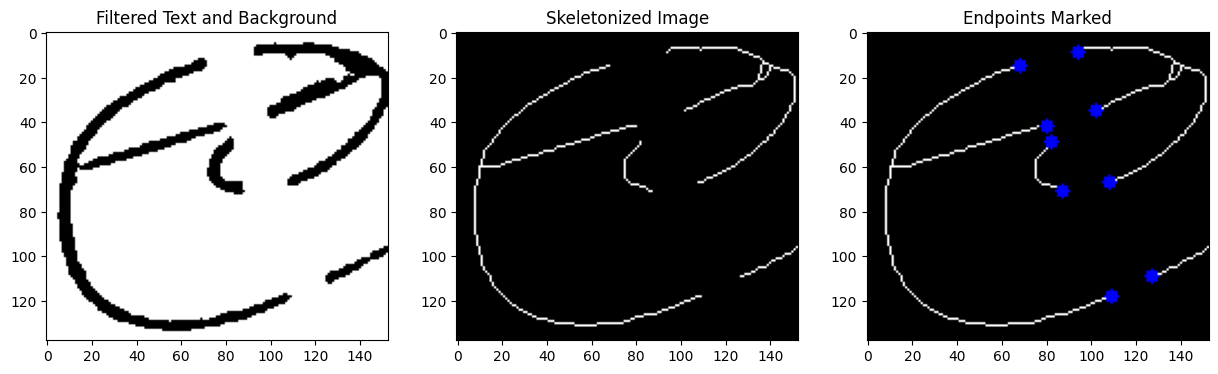

Endpoint-marked image saved as: /content/endpoints_detected.png


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert

# Function to Detect Endpoints
def detect_endpoints(skeleton):
    endpoints = []

    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 255:  # Foreground pixel
                # Count number of 8-connected neighbors
                neighbors = [
                    skeleton[y-1, x-1], skeleton[y-1, x], skeleton[y-1, x+1],
                    skeleton[y, x-1],                     skeleton[y, x+1],
                    skeleton[y+1, x-1], skeleton[y+1, x], skeleton[y+1, x+1]
                ]
                if np.sum(neighbors) == 255:  # Only one neighbor → Endpoint
                    endpoints.append((x, y))

    return endpoints

# Load the Cleaned Text-Background Image (Previous Output)
cleaned_image_path = "/content/text_background_filtered.png"
cleaned_img = cv2.imread(cleaned_image_path, cv2.IMREAD_GRAYSCALE)

# Convert to Binary
_, binary = cv2.threshold(cleaned_img, 128, 255, cv2.THRESH_BINARY_INV)

# Apply Skeletonization
skeleton = skeletonize(binary // 255) * 255  # Normalize back to 0-255

# Detect Endpoints
endpoints = detect_endpoints(skeleton)

# Mark Endpoints on the Image
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)
for x, y in endpoints:
    cv2.circle(skeleton_colored, (x, y), 3, (0, 0, 255), -1)  # Red dots for endpoints

# Display Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cleaned_img, cmap='gray')
plt.title("Filtered Text and Background")

plt.subplot(1, 3, 2)
plt.imshow(skeleton, cmap='gray')
plt.title("Skeletonized Image")

plt.subplot(1, 3, 3)
plt.imshow(skeleton_colored)
plt.title("Endpoints Marked")

plt.show()

# Save the output
output_path = "/content/endpoints_detected.png"
cv2.imwrite(output_path, skeleton_colored)
print(f"Endpoint-marked image saved as: {output_path}")


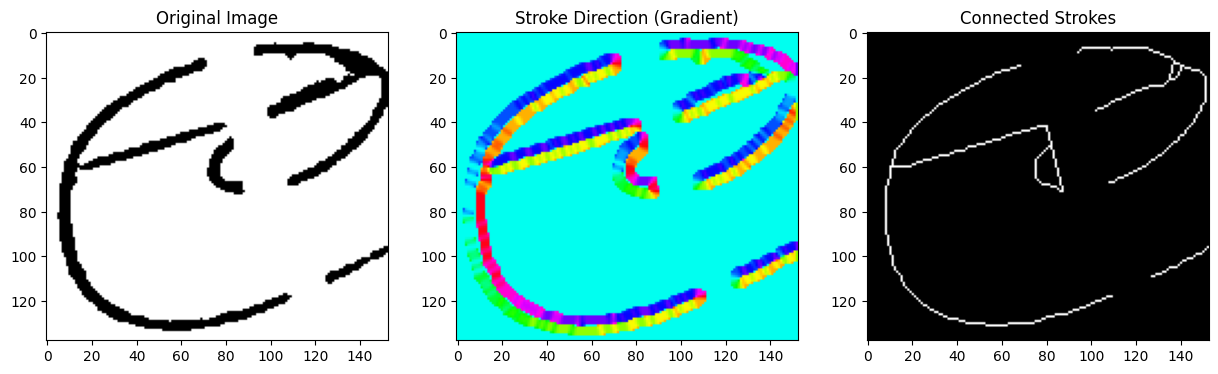

Connected strokes image saved: /content/connected_strokes.png


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from skimage.morphology import skeletonize
from scipy.spatial import distance

# ✅ Step 1: Compute Gradient Direction on Original Image (Before Skeletonization)
def compute_gradient_direction(original_image):
    """Compute stroke direction using Sobel gradient before skeletonization"""
    sobelx = cv2.Sobel(original_image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(original_image, cv2.CV_64F, 0, 1, ksize=5)
    gradient_direction = np.arctan2(sobely, sobelx)  # Compute orientation
    return gradient_direction

# ✅ Step 2: Perform Skeletonization
def skeletonize_image(binary_image):
    """Skeletonize the image to reduce strokes to 1-pixel width"""
    return (skeletonize(binary_image // 255) * 255).astype(np.uint8)

# ✅ Step 3: Detect Endpoints in the Skeleton
def detect_endpoints(skeleton):
    """Detect stroke endpoints in the skeletonized image"""
    endpoints = []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 255:  # Foreground pixel
                neighbors = np.sum(skeleton[y-1:y+2, x-1:x+2] == 255) - 1  # Count 8-neighbors
                if neighbors == 1:  # Endpoint if it has only one neighbor
                    endpoints.append((x, y))
    return endpoints

# ✅ Step 4: Connect Endpoints Based on Stroke Flow
def connect_endpoints(skeleton, endpoints, gradient_direction, max_dist=30):
    """Connect stroke endpoints intelligently using direction analysis"""
    G = nx.Graph()

    for i, (x1, y1) in enumerate(endpoints):
        for j, (x2, y2) in enumerate(endpoints):
            if i != j:
                dist = distance.euclidean((x1, y1), (x2, y2))

                # Only consider points within the threshold
                if dist < max_dist:
                    # Get gradient direction at both points
                    theta1 = gradient_direction[y1, x1]
                    theta2 = gradient_direction[y2, x2]

                    # Only connect if stroke direction is similar
                    if np.abs(theta1 - theta2) < np.pi / 6:  # Angle threshold (30 degrees)
                        G.add_edge(i, j, weight=dist)

    # Find minimum spanning tree for meaningful stroke connection
    mst = nx.minimum_spanning_tree(G)

    # Draw connections
    connected_skeleton = skeleton.copy()
    for i, j in mst.edges():
        pt1, pt2 = endpoints[i], endpoints[j]
        cv2.line(connected_skeleton, pt1, pt2, 255, 1)

    return connected_skeleton

# ✅ Step 5: Load Image and Process
image_path = "/content/text_background_filtered.png"
original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Convert to Binary
_, binary = cv2.threshold(original_img, 128, 255, cv2.THRESH_BINARY_INV)

# 🔥 Extract Stroke Direction BEFORE Skeletonization
gradient_direction = compute_gradient_direction(binary)

# Apply Skeletonization
skeleton = skeletonize_image(binary)

# Detect Endpoints
endpoints = detect_endpoints(skeleton)

# Connect Endpoints Based on Stroke Flow
connected_skeleton = connect_endpoints(skeleton, endpoints, gradient_direction)

# ✅ Display Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(gradient_direction, cmap='hsv')
plt.title("Stroke Direction (Gradient)")

plt.subplot(1, 3, 3)
plt.imshow(connected_skeleton, cmap='gray')
plt.title("Connected Strokes")

plt.show()

# ✅ Save Output
output_path = "/content/connected_strokes.png"
cv2.imwrite(output_path, connected_skeleton)
print(f"Connected strokes image saved: {output_path}")


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert
from scipy.interpolate import splprep, splev
from skimage.measure import find_contours

### Step 1: Pre-Processing and Image Cleaning ###

def preprocess_image(image_path):
    """Load and preprocess image (convert to grayscale, remove holes, and threshold)."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError("Image file not found!")

    # Adaptive thresholding to binarize the image
    binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 10)

    # Morphological opening to remove noise
    kernel = np.ones((2,2), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    return cleaned

### Step 2: Compute Stroke Flow (Gradient) BEFORE Skeletonization ###

def compute_gradient_direction(image):
    """Compute stroke gradient direction before skeletonization."""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    gradient_direction = np.arctan2(sobely, sobelx)  # Compute orientation
    return gradient_direction

### Step 3: Extract Stroke Segments (Before Thinning) ###

def extract_stroke_segments(image):
    """Extract stroke segments before thinning."""
    contours = find_contours(image, 0.5)
    return [np.flip(contour, axis=1) for contour in contours]

### Step 4: Skeletonization and Endpoint Detection ###

def detect_endpoints(skeleton):
    """Detect endpoints in the skeletonized image."""
    endpoints = []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 255:
                neighbors = np.sum(skeleton[y - 1:y + 2, x - 1:x + 2] == 255) - 1
                if neighbors == 1:
                    endpoints.append((x, y))
    return endpoints

### Step 5: Stroke Reconstruction (Bezier Curve) ###

def bezier_curve(points, num=100):
    """Generate a smooth Bezier curve from given points."""
    points = np.array(points)
    tck, u = splprep([points[:, 0], points[:, 1]], s=0, k=2)
    u_new = np.linspace(0, 1, num)
    smooth_points = np.array(splev(u_new, tck)).T
    return smooth_points

### Step 6: Connect Endpoints based on Stroke Flow ###

def connect_endpoints(image, endpoints, gradient_direction, max_distance=20, angle_threshold=np.pi / 4):
    """ Connect relevant endpoints based on stroke flow """

    connected_image = np.array(image, dtype=np.uint8)  # Ensure uint8 image format
    used = set()

    for i, (x1, y1) in enumerate(endpoints):
        if i in used:
            continue
        min_dist = max_distance
        best_match = None

        for j, (x2, y2) in enumerate(endpoints):
            if i == j or j in used:
                continue

            dist = np.linalg.norm([x2 - x1, y2 - y1])
            if dist < min_dist:
                angle_diff = abs(gradient_direction[y1, x1] - gradient_direction[y2, x2])
                if angle_diff < angle_threshold:
                    min_dist = dist
                    best_match = (x2, y2, j)

        if best_match:
            x2, y2, j = best_match
            used.add(i)
            used.add(j)

            # Generate smooth connection using Bezier curve
            smooth_points = bezier_curve([(x1, y1), ((x1 + x2) // 2, (y1 + y2) // 2), (x2, y2)])
            for px, py in smooth_points:
                cv2.circle(connected_image, (int(px), int(py)), 1, (255, 255, 255), -1)  # Fixed data type issue

    return connected_image


### Step 7: Integrate All Steps & Process the Image ###

# Load and preprocess the image
image_path = 'text_background_filtered.png'  # Use your preprocessed image
preprocessed_image = preprocess_image(image_path)

# Compute stroke gradient before skeletonization
gradient_direction = compute_gradient_direction(preprocessed_image)

# Extract stroke segments before thinning
stroke_segments = extract_stroke_segments(preprocessed_image)

# Perform skeletonization
binary = cv2.threshold(preprocessed_image, 128, 255, cv2.THRESH_BINARY_INV)[1]
skeleton = skeletonize(binary / 255) * 255

# Detect endpoints
endpoints = detect_endpoints(skeleton)

# Connect relevant endpoints using Bezier curves
connected_strokes = connect_endpoints(skeleton, endpoints, gradient_direction)

# Display results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(gradient_direction, cmap='hsv')
ax[0].set_title("Stroke Direction (Gradient)")
ax[1].imshow(connected_strokes, cmap='gray')
ax[1].set_title("Connected Strokes")
plt.show()

# Save the output
cv2.imwrite("reconstructed_strokes.png", connected_strokes)


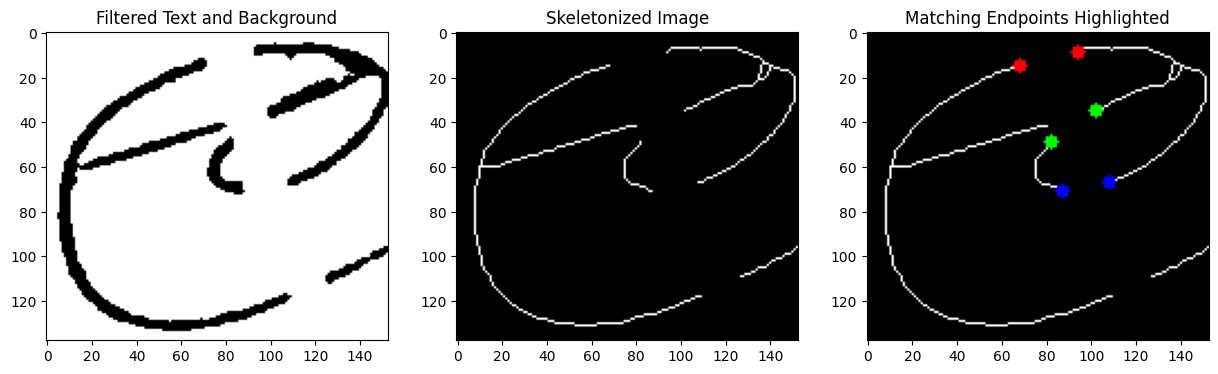

Matching endpoint image saved as: /content/matching_endpoints.png


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert

# Function to compute gradient direction (Stroke orientation)
def compute_gradient_direction(binary_image):
    # Convert skeletonized image to uint8 format
    binary_image = (binary_image * 255).astype(np.uint8)

    # Apply slight Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(binary_image, (3, 3), 0)

    # Compute Sobel gradients
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal gradient
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)  # Vertical gradient

    # Compute gradient orientation
    gradient_direction = np.arctan2(sobely, sobelx)

    return gradient_direction

# Function to Detect Endpoints
def detect_endpoints(skeleton):
    endpoints = []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 255:  # Foreground pixel
                # Count number of 8-connected neighbors
                neighbors = [
                    skeleton[y-1, x-1], skeleton[y-1, x], skeleton[y-1, x+1],
                    skeleton[y, x-1],                     skeleton[y, x+1],
                    skeleton[y+1, x-1], skeleton[y+1, x], skeleton[y+1, x+1]
                ]
                if np.sum(neighbors) == 255:  # Only one neighbor → Endpoint
                    endpoints.append((x, y))
    return endpoints

# Function to find and group matching endpoints based on stroke direction
def match_endpoints_by_direction(endpoints, gradient_direction, max_angle_diff=15):
    endpoint_groups = []  # List to hold matching pairs
    used = set()  # Track used endpoints

    for i, (x1, y1) in enumerate(endpoints):
        if i in used:
            continue
        best_match = None
        min_angle_diff = float('inf')

        # Get gradient direction at this endpoint
        angle1 = np.degrees(gradient_direction[y1, x1])

        for j, (x2, y2) in enumerate(endpoints):
            if j == i or j in used:
                continue

            # Get gradient direction at the potential match
            angle2 = np.degrees(gradient_direction[y2, x2])

            # Compute angle difference
            angle_diff = abs(angle1 - angle2)

            # If angle difference is within the threshold, it's a match
            if angle_diff < max_angle_diff and np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2])) < 40:
                if angle_diff < min_angle_diff:  # Choose the best match
                    best_match = j
                    min_angle_diff = angle_diff

        if best_match is not None:
            endpoint_groups.append(((x1, y1), endpoints[best_match]))
            used.add(i)
            used.add(best_match)

    return endpoint_groups

# Load the Cleaned Text-Background Image (Previous Output)
cleaned_image_path = "/content/text_background_filtered.png"
cleaned_img = cv2.imread(cleaned_image_path, cv2.IMREAD_GRAYSCALE)

# Convert to Binary
_, binary = cv2.threshold(cleaned_img, 128, 255, cv2.THRESH_BINARY_INV)

# Apply Skeletonization
skeleton = skeletonize(binary // 255) * 255  # Normalize back to 0-255

# Compute gradient direction map
gradient_direction = compute_gradient_direction(skeleton)

# Detect Endpoints
endpoints = detect_endpoints(skeleton)

# Match suitable endpoints based on stroke direction
matched_endpoints = match_endpoints_by_direction(endpoints, gradient_direction)

# Mark Endpoints and Matched Pairs on the Image
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)

# Assign different colors for different pairs
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]
color_index = 0

for (x1, y1), (x2, y2) in matched_endpoints:
    color = colors[color_index % len(colors)]
    cv2.circle(skeleton_colored, (x1, y1), 3, color, -1)  # Mark first endpoint
    cv2.circle(skeleton_colored, (x2, y2), 3, color, -1)  # Mark matching endpoint
    color_index += 1

# Display Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cleaned_img, cmap='gray')
plt.title("Filtered Text and Background")

plt.subplot(1, 3, 2)
plt.imshow(skeleton, cmap='gray')
plt.title("Skeletonized Image")

plt.subplot(1, 3, 3)
plt.imshow(skeleton_colored)
plt.title("Matching Endpoints Highlighted")

plt.show()

# Save the output
output_path = "/content/matching_endpoints.png"
cv2.imwrite(output_path, skeleton_colored)
print(f"Matching endpoint image saved as: {output_path}")


Total detected endpoints: 9
Total matched pairs: 3
Unmatched endpoints: 3


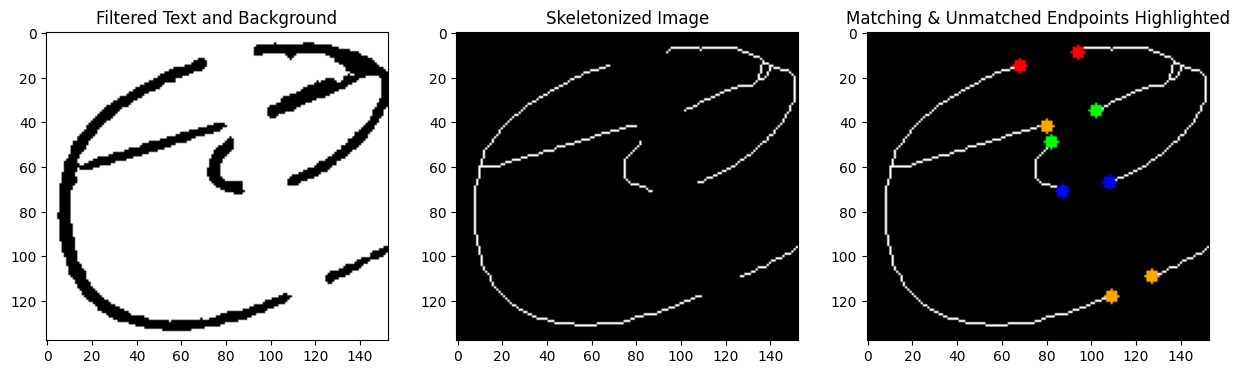

Matching endpoint image saved as: /content/matching_endpoints_fixed.png


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert

# Function to compute gradient direction (Stroke orientation)
def compute_gradient_direction(binary_image):
    binary_image = (binary_image * 255).astype(np.uint8)  # Ensure correct format
    blurred = cv2.GaussianBlur(binary_image, (3, 3), 0)

    # Compute Sobel gradients
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal gradient
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)  # Vertical gradient

    gradient_direction = np.arctan2(sobely, sobelx)
    return gradient_direction

# Function to Detect Endpoints
def detect_endpoints(skeleton):
    endpoints = []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 255:  # Foreground pixel
                neighbors = [
                    skeleton[y-1, x-1], skeleton[y-1, x], skeleton[y-1, x+1],
                    skeleton[y, x-1],                     skeleton[y, x+1],
                    skeleton[y+1, x-1], skeleton[y+1, x], skeleton[y+1, x+1]
                ]
                if np.sum(neighbors) == 255:  # Only one neighbor → Endpoint
                    endpoints.append((x, y))
    return endpoints

# Function to find and group matching endpoints based on stroke direction
def match_endpoints_by_direction(endpoints, gradient_direction, max_angle_diff=15, max_distance=40):
    endpoint_groups = []
    used = set()

    for i, (x1, y1) in enumerate(endpoints):
        if i in used:
            continue
        best_match = None
        min_angle_diff = float('inf')

        angle1 = np.degrees(gradient_direction[y1, x1])

        for j, (x2, y2) in enumerate(endpoints):
            if j == i or j in used:
                continue

            angle2 = np.degrees(gradient_direction[y2, x2])
            angle_diff = abs(angle1 - angle2)

            if angle_diff < max_angle_diff and np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2])) < max_distance:
                if angle_diff < min_angle_diff:
                    best_match = j
                    min_angle_diff = angle_diff

        if best_match is not None:
            endpoint_groups.append(((x1, y1), endpoints[best_match]))
            used.add(i)
            used.add(best_match)

    return endpoint_groups, used

# Load the Cleaned Text-Background Image
cleaned_image_path = "/content/text_background_filtered.png"
cleaned_img = cv2.imread(cleaned_image_path, cv2.IMREAD_GRAYSCALE)

# Convert to Binary
_, binary = cv2.threshold(cleaned_img, 128, 255, cv2.THRESH_BINARY_INV)

# Apply Skeletonization
skeleton = skeletonize(binary // 255) * 255

# Compute gradient direction map
gradient_direction = compute_gradient_direction(skeleton)

# Detect Endpoints
endpoints = detect_endpoints(skeleton)

# Match suitable endpoints based on stroke direction
matched_endpoints, used_endpoints = match_endpoints_by_direction(endpoints, gradient_direction)

# Debugging: Print total detected endpoints and matched pairs
print(f"Total detected endpoints: {len(endpoints)}")
print(f"Total matched pairs: {len(matched_endpoints)}")
print(f"Unmatched endpoints: {len(endpoints) - len(used_endpoints)}")

# Mark Endpoints and Matched Pairs on the Image
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)

# Assign different colors for different pairs (BGR format)
colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255), (255, 0, 255), (0, 255, 255)]
color_index = 0

# Draw matched pairs
for index, ((x1, y1), (x2, y2)) in enumerate(matched_endpoints):
    color = colors[index % len(colors)]
    cv2.circle(skeleton_colored, (x1, y1), 3, color, -1)
    cv2.circle(skeleton_colored, (x2, y2), 3, color, -1)

# 🚀 **Fix: Ensure Unmatched Endpoints Are Orange** 🚀
for i, (x, y) in enumerate(endpoints):
    if i not in used_endpoints:
        cv2.circle(skeleton_colored, (x, y), 3, (0, 165, 255), -1)  # ORANGE for unmatched

# **Convert BGR to RGB for Matplotlib**
skeleton_colored_rgb = cv2.cvtColor(skeleton_colored, cv2.COLOR_BGR2RGB)

# Display Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cleaned_img, cmap='gray')
plt.title("Filtered Text and Background")

plt.subplot(1, 3, 2)
plt.imshow(skeleton, cmap='gray')
plt.title("Skeletonized Image")

plt.subplot(1, 3, 3)
plt.imshow(skeleton_colored_rgb)
plt.title("Matching & Unmatched Endpoints Highlighted")

plt.show()

# Save the output
output_path = "/content/matching_endpoints_fixed.png"
cv2.imwrite(output_path, skeleton_colored)
print(f"Matching endpoint image saved as: {output_path}")


Total detected endpoints: 9
Total matched pairs: 3
Unmatched endpoints: 3


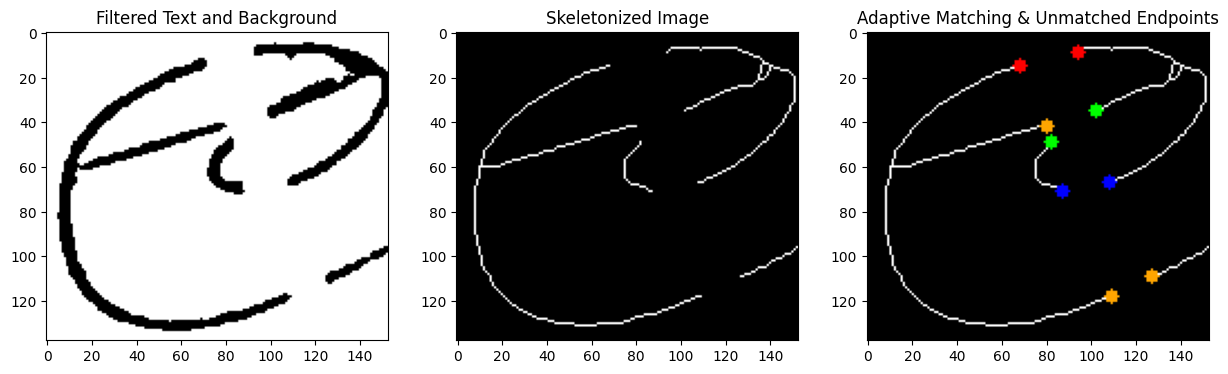

Matching endpoint image saved as: /content/adaptive_matching.png


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

# Function to compute gradient direction (Stroke orientation)
def compute_gradient_direction(binary_image):
    binary_image = (binary_image * 255).astype(np.uint8)  # Ensure correct format
    blurred = cv2.GaussianBlur(binary_image, (3, 3), 0)

    # Compute Sobel gradients
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal gradient
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)  # Vertical gradient

    return np.arctan2(sobely, sobelx)

# Function to Detect Endpoints
def detect_endpoints(skeleton):
    endpoints = []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 255:  # Foreground pixel
                neighbors = [
                    skeleton[y-1, x-1], skeleton[y-1, x], skeleton[y-1, x+1],
                    skeleton[y, x-1],                     skeleton[y, x+1],
                    skeleton[y+1, x-1], skeleton[y+1, x], skeleton[y+1, x+1]
                ]
                if np.sum(neighbors) == 255:  # Only one neighbor → Endpoint
                    endpoints.append((x, y))
    return endpoints

# Adaptive matching approach
def match_endpoints_adaptive(endpoints, gradient_direction, min_distance=8, max_distance=40, angle_step=1, max_angle=15):
    endpoint_groups = []
    used = set()

    for i, (x1, y1) in enumerate(endpoints):
        if i in used:
            continue

        angle1 = np.degrees(gradient_direction[y1, x1])
        best_match = None
        min_angle_diff = float('inf')

        # Adaptive search: Increase distance first, then relax angle
        for angle_threshold in range(5, max_angle + 1, angle_step):
            for dist_threshold in range(min_distance, max_distance + 1, 5):
                for j, (x2, y2) in enumerate(endpoints):
                    if j == i or j in used:
                        continue

                    angle2 = np.degrees(gradient_direction[y2, x2])
                    angle_diff = abs(angle1 - angle2)

                    if angle_diff < angle_threshold and np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2])) < dist_threshold:
                        if angle_diff < min_angle_diff:
                            best_match = j
                            min_angle_diff = angle_diff

                if best_match is not None:
                    break  # Found a match, no need to increase distance further

            if best_match is not None:
                break  # Found a match, no need to increase angle further

        if best_match is not None:
            endpoint_groups.append(((x1, y1), endpoints[best_match]))
            used.add(i)
            used.add(best_match)

    return endpoint_groups, used

# Load the Cleaned Text-Background Image
cleaned_image_path = "/content/text_background_filtered.png"
cleaned_img = cv2.imread(cleaned_image_path, cv2.IMREAD_GRAYSCALE)

# Convert to Binary
_, binary = cv2.threshold(cleaned_img, 128, 255, cv2.THRESH_BINARY_INV)

# Apply Skeletonization
skeleton = skeletonize(binary // 255) * 255

# Compute gradient direction map
gradient_direction = compute_gradient_direction(skeleton)

# Detect Endpoints
endpoints = detect_endpoints(skeleton)

# Match suitable endpoints using the adaptive strategy
matched_endpoints, used_endpoints = match_endpoints_adaptive(endpoints, gradient_direction)

# Debugging: Print total detected endpoints and matched pairs
print(f"Total detected endpoints: {len(endpoints)}")
print(f"Total matched pairs: {len(matched_endpoints)}")
print(f"Unmatched endpoints: {len(endpoints) - len(used_endpoints)}")

# Mark Endpoints and Matched Pairs on the Image
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)

# Assign different colors for different pairs (BGR format)
colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255), (255, 0, 255), (0, 255, 255)]
color_index = 0

# Draw matched pairs
for index, ((x1, y1), (x2, y2)) in enumerate(matched_endpoints):
    color = colors[index % len(colors)]
    cv2.circle(skeleton_colored, (x1, y1), 3, color, -1)
    cv2.circle(skeleton_colored, (x2, y2), 3, color, -1)

# **Highlight Unmatched Endpoints in Orange**
for i, (x, y) in enumerate(endpoints):
    if i not in used_endpoints:
        cv2.circle(skeleton_colored, (x, y), 3, (0, 165, 255), -1)  # ORANGE for unmatched

# **Convert BGR to RGB for Matplotlib**
skeleton_colored_rgb = cv2.cvtColor(skeleton_colored, cv2.COLOR_BGR2RGB)

# Display Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cleaned_img, cmap='gray')
plt.title("Filtered Text and Background")

plt.subplot(1, 3, 2)
plt.imshow(skeleton, cmap='gray')
plt.title("Skeletonized Image")

plt.subplot(1, 3, 3)
plt.imshow(skeleton_colored_rgb)
plt.title("Adaptive Matching & Unmatched Endpoints")

plt.show()

# Save the output
output_path = "/content/adaptive_matching.png"
cv2.imwrite(output_path, skeleton_colored)
print(f"Matching endpoint image saved as: {output_path}")


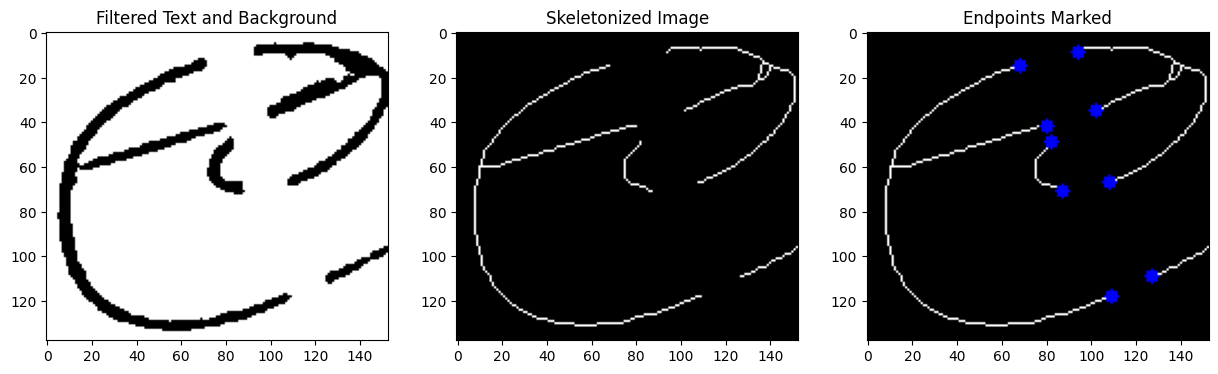

Endpoint-marked image saved as: /content/endpoints_detected.png


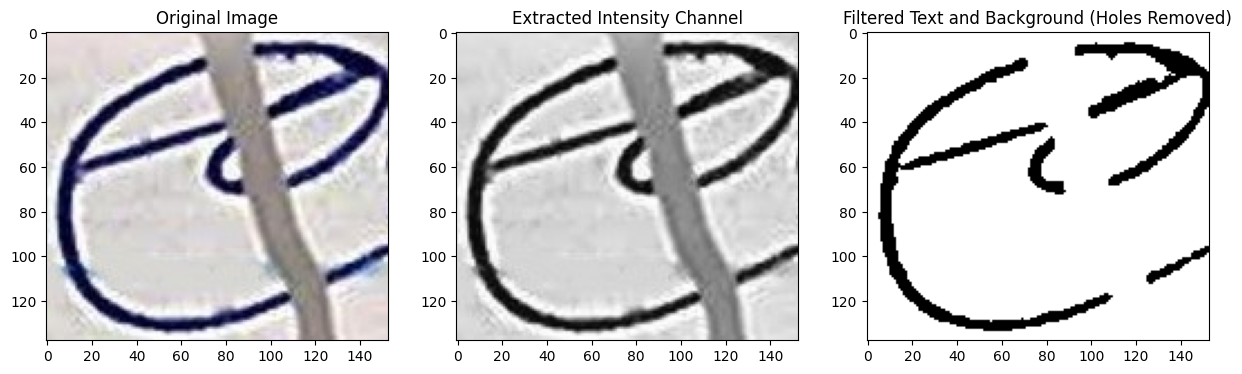

Cleaned image saved as: /content/text_background_filtered.png


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function to Convert RGB to HSI and Extract Intensity
def rgb_to_hsi(image):
    img = image.astype(np.float32) / 255.0
    B, G, R = cv2.split(img)

    I = (R + G + B) / 3  # Intensity

    I = (I * 255).astype(np.uint8)  # Convert to 8-bit
    return I

# Function to Apply K-Means Clustering (k=3) and Filter Out Holes
def extract_text_and_background(image_path):
    # Load Image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Convert to HSI and Extract Intensity
    I = rgb_to_hsi(img)

    # Reshape Intensity for K-Means Clustering
    pixels = I.reshape(-1, 1)  # Flattened intensity values
    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(pixels)
    clustered = kmeans.labels_.reshape(I.shape)  # Reshape back to original image size

    # Identify Clusters: Text, Hole, Background (Sort by intensity)
    cluster_means = [np.mean(pixels[kmeans.labels_ == i]) for i in range(3)]  # Fix: Use kmeans.labels_
    sorted_clusters = np.argsort(cluster_means)  # Sort clusters by intensity

    text_cluster = sorted_clusters[0]         # Darkest region (Text)
    hole_cluster = sorted_clusters[1]         # Mid-Grey region (Hole)
    background_cluster = sorted_clusters[2]   # Brightest region (Background)

    # Remove Hole Region (Set to Background)
    cleaned_mask = np.where(clustered == hole_cluster, background_cluster, clustered)
    cleaned_mask = np.where(cleaned_mask == text_cluster, 0, 255).astype(np.uint8)  # Keep text as black, rest white

    # Plot Results
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")

    # Intensity Image
    plt.subplot(1, 3, 2)
    plt.imshow(I, cmap='gray')
    plt.title("Extracted Intensity Channel")

    # Cleaned Image (Without Holes)
    plt.subplot(1, 3, 3)
    plt.imshow(cleaned_mask, cmap='gray')
    plt.title("Filtered Text and Background (Holes Removed)")

    plt.show()

    # Save the Output
    output_path = "/content/text_background_filtered.png"
    cv2.imwrite(output_path, cleaned_mask)
    print(f"Cleaned image saved as: {output_path}")

    # Load the Cleaned Text-Background Image (Previous Output)
    cleaned_image_path = "/content/text_background_filtered.png"
    cleaned_img = cv2.imread(cleaned_image_path, cv2.IMREAD_GRAYSCALE)

    # Convert to Binary
    _, binary = cv2.threshold(cleaned_img, 128, 255, cv2.THRESH_BINARY_INV)

# Apply Skeletonization
skeleton = skeletonize(binary // 255) * 255  # Normalize back to 0-255

# Detect Endpoints
endpoints = detect_endpoints(skeleton)

# Mark Endpoints on the Image
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)
for x, y in endpoints:
    cv2.circle(skeleton_colored, (x, y), 3, (0, 0, 255), -1)  # Red dots for endpoints

# Display Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cleaned_img, cmap='gray')
plt.title("Filtered Text and Background")

plt.subplot(1, 3, 2)
plt.imshow(skeleton, cmap='gray')
plt.title("Skeletonized Image")

plt.subplot(1, 3, 3)
plt.imshow(skeleton_colored)
plt.title("Endpoints Marked")

plt.show()

# Save the output
output_path = "/content/endpoints_detected.png"
cv2.imwrite(output_path, skeleton_colored)
print(f"Endpoint-marked image saved as: {output_path}")



# Run on Colab
image_path = "/content/minorSeg.jpeg"
extract_text_and_background(image_path)


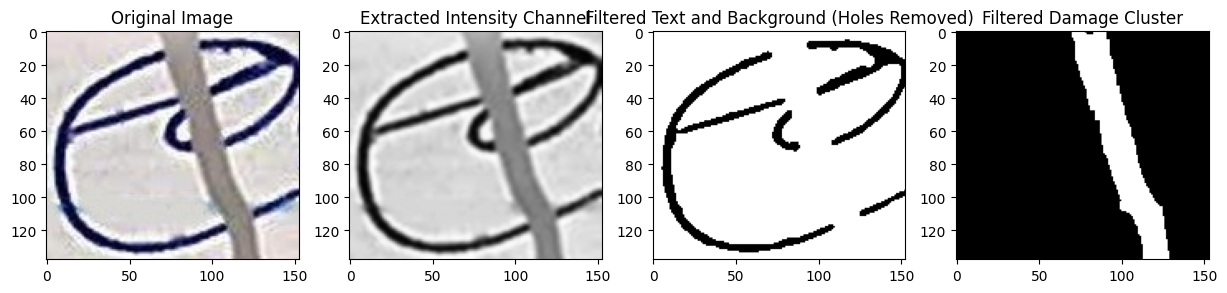

Cleaned image saved as: /content/text_background_filtered.png


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.morphology import skeletonize

# Function to Convert RGB to HSI and Extract Intensity
def rgb_to_hsi(image):
    img = image.astype(np.float32) / 255.0
    B, G, R = cv2.split(img)
    I = (R + G + B) / 3  # Intensity
    I = (I * 255).astype(np.uint8)  # Convert to 8-bit
    return I

# Function to Apply K-Means Clustering (k=3) and Filter Out Holes
def extract_text_and_background(image_path):
    # Load Image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Apply Gaussian Blur to Reduce Noise
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)  # Blur with a 5x5 kernel

    # Convert to HSI and Extract Intensity
    I = rgb_to_hsi(img_blur)

    # Reshape Intensity for K-Means Clustering
    pixels = I.reshape(-1, 1)  # Flattened intensity values
    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(pixels)
    clustered = kmeans.labels_.reshape(I.shape)  # Reshape back to original image size

    # Identify Clusters: Text, Hole, Background (Sort by intensity)
    cluster_means = [np.mean(pixels[kmeans.labels_ == i]) for i in range(3)]
    sorted_clusters = np.argsort(cluster_means)  # Sort clusters by intensity

    text_cluster = sorted_clusters[0]         # Darkest region (Text)
    hole_cluster = sorted_clusters[1]         # Mid-Grey region (Hole)
    background_cluster = sorted_clusters[2]   # Brightest region (Background)

    # Detect Damage Cluster (Hole Region)
    hole_mask = (clustered == hole_cluster).astype(np.uint8) * 255  # Binary mask of holes

    # **Apply Morphological Opening to Remove Small Noise**
    kernel = np.ones((3, 3), np.uint8)
    hole_mask_cleaned = cv2.morphologyEx(hole_mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find Contours of the Damage Cluster
    contours, _ = cv2.findContours(hole_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # **Remove Small False Positive Clusters**
    min_contour_area = 200  # Threshold: Remove any cluster smaller than this
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    # Draw Filtered Contours on a Blank Mask
    hole_mask_final = np.zeros_like(hole_mask)
    cv2.drawContours(hole_mask_final, filtered_contours, -1, (255), thickness=cv2.FILLED)

    # Remove Hole Region (Set to Background)
    cleaned_mask = np.where(clustered == hole_cluster, background_cluster, clustered)
    cleaned_mask = np.where(cleaned_mask == text_cluster, 0, 255).astype(np.uint8)  # Keep text as black, rest white

    # Plot Results
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title("Original Image")

    # Intensity Image
    plt.subplot(1, 4, 2)
    plt.imshow(I, cmap='gray')
    plt.title("Extracted Intensity Channel")

    # Cleaned Image (Without Holes)
    plt.subplot(1, 4, 3)
    plt.imshow(cleaned_mask, cmap='gray')
    plt.title("Filtered Text and Background (Holes Removed)")

    # Damage Cluster Detection (After Smoothing & Filtering)
    plt.subplot(1, 4, 4)
    plt.imshow(hole_mask_final, cmap='gray')
    plt.title("Filtered Damage Cluster")

    plt.show()

    # Save the Output
    output_path = "/content/text_background_filtered.png"
    cv2.imwrite(output_path, cleaned_mask)
    print(f"Cleaned image saved as: {output_path}")

    return cleaned_mask, hole_mask_final

# Load Image and Extract Cleaned Text & Filtered Damage Cluster
image_path = "/content/minorSeg.jpeg"
cleaned_mask, hole_mask_final = extract_text_and_background(image_path)


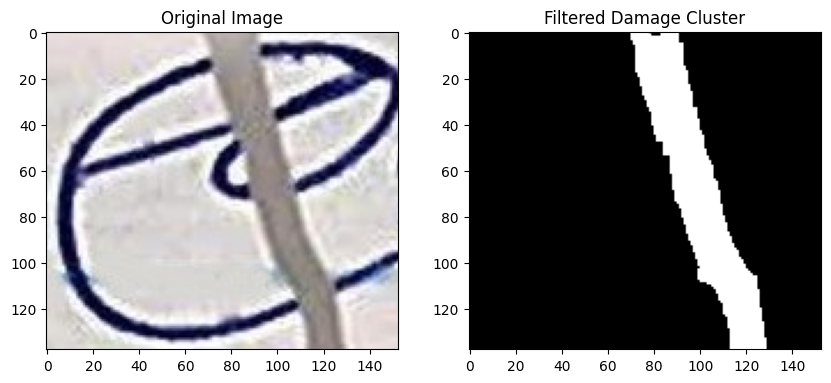

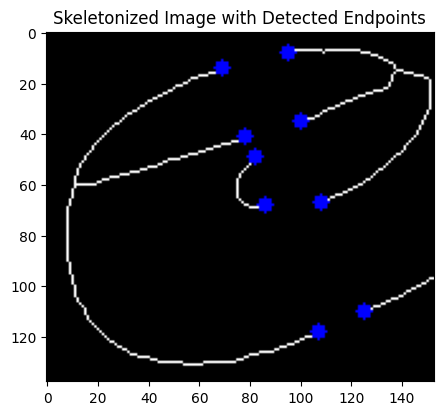

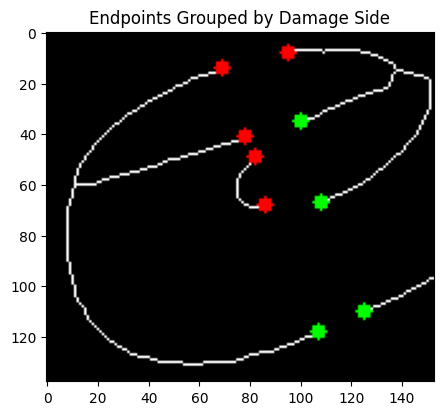

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.morphology import skeletonize
from scipy.spatial.distance import cdist

# Function to Convert RGB to HSI and Extract Intensity
def rgb_to_hsi(image):
    img = image.astype(np.float32) / 255.0
    B, G, R = cv2.split(img)
    I = (R + G + B) / 3  # Intensity
    return (I * 255).astype(np.uint8)

# Function to Apply K-Means Clustering and Detect Damage Cluster
def extract_text_and_background(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply Gaussian Blur to Reduce Noise
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Convert to HSI and Extract Intensity
    I = rgb_to_hsi(img_blur)

    # K-Means Clustering for Damage Detection
    pixels = I.reshape(-1, 1)
    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(pixels)
    clustered = kmeans.labels_.reshape(I.shape)

    # Identify Clusters
    cluster_means = [np.mean(pixels[kmeans.labels_ == i]) for i in range(3)]
    sorted_clusters = np.argsort(cluster_means)

    text_cluster = sorted_clusters[0]
    hole_cluster = sorted_clusters[1]
    background_cluster = sorted_clusters[2]

    # Damage Mask
    hole_mask = (clustered == hole_cluster).astype(np.uint8) * 255

    # Apply Morphological Opening (Remove Small Noise)
    kernel = np.ones((3, 3), np.uint8)
    hole_mask_cleaned = cv2.morphologyEx(hole_mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find Damage Contours
    contours, _ = cv2.findContours(hole_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_contour_area = 200
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    # Draw Cleaned Damage Mask
    hole_mask_final = np.zeros_like(hole_mask)
    cv2.drawContours(hole_mask_final, filtered_contours, -1, (255), thickness=cv2.FILLED)

    # Get Damage Bounding Box & Centroid
    if filtered_contours:
        largest_contour = max(filtered_contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        centroid_x = x + w // 2
        centroid_y = y + h // 2
        max_matching_distance = max(w, h) * 1.2
        damage_orientation = "vertical" if h > w else "horizontal"
    else:
        centroid_x = I.shape[1] // 2
        centroid_y = I.shape[0] // 2
        max_matching_distance = 50
        damage_orientation = "vertical"

    # **Step 1: Show Damage Cluster Detection**
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(hole_mask_final, cmap='gray')
    plt.title("Filtered Damage Cluster")
    plt.show()

    return hole_mask_final, centroid_x, centroid_y, max_matching_distance, damage_orientation

# Function to Detect Endpoints
def detect_endpoints(skeleton):
    endpoints = []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 255:
                neighbors = [
                    skeleton[y-1, x-1], skeleton[y-1, x], skeleton[y-1, x+1],
                    skeleton[y, x-1],                     skeleton[y, x+1],
                    skeleton[y+1, x-1], skeleton[y+1, x], skeleton[y+1, x+1]
                ]
                if np.sum(neighbors) == 255:
                    endpoints.append((x, y))

    return endpoints

# Load Image and Process
image_path = "/content/minorSeg.jpeg"
hole_mask, centroid_x, centroid_y, max_matching_distance, damage_orientation = extract_text_and_background(image_path)

# Load Processed Image
cleaned_img = cv2.imread("/content/text_background_filtered.png", cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(cleaned_img, 128, 255, cv2.THRESH_BINARY_INV)

# Apply Skeletonization
skeleton = skeletonize(binary // 255) * 255

# Detect Endpoints
endpoints = detect_endpoints(skeleton)

# **Step 2: Show Skeletonized Image with Endpoints**
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)
for x, y in endpoints:
    cv2.circle(skeleton_colored, (x, y), 3, (0, 0, 255), -1)

plt.figure(figsize=(5, 5))
plt.imshow(skeleton_colored)
plt.title("Skeletonized Image with Detected Endpoints")
plt.show()

# Function to Group Endpoints Based on Damage Orientation
def group_endpoints_by_damage(endpoints, centroid_x, centroid_y, damage_orientation):
    if damage_orientation == "vertical":
        left_side = [pt for pt in endpoints if pt[0] < centroid_x]
        right_side = [pt for pt in endpoints if pt[0] >= centroid_x]
        return left_side, right_side
    else:
        top_side = [pt for pt in endpoints if pt[1] < centroid_y]
        bottom_side = [pt for pt in endpoints if pt[1] >= centroid_y]
        return top_side, bottom_side

# Group Endpoints
group1, group2 = group_endpoints_by_damage(endpoints, centroid_x, centroid_y, damage_orientation)

# **Step 3: Show Grouped Endpoints**
for x, y in group1:
    cv2.circle(skeleton_colored, (x, y), 3, (255, 0, 0), -1)  # Red for group 1
for x, y in group2:
    cv2.circle(skeleton_colored, (x, y), 3, (0, 255, 0), -1)  # Green for group 2

plt.figure(figsize=(5, 5))
plt.imshow(skeleton_colored)
plt.title("Endpoints Grouped by Damage Side")
plt.show()

# **Next Steps: Implement Multi-Step Matching & Show Matched Endpoints**


<ipython-input-32-9ab71f8aff1d>:58: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


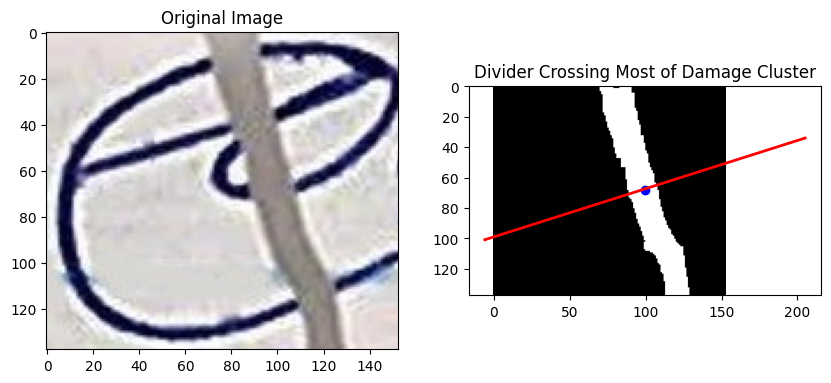

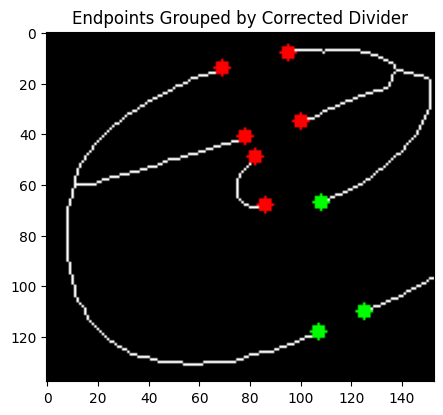

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.morphology import skeletonize
from scipy.spatial.distance import cdist

# Function to Convert RGB to HSI and Extract Intensity
def rgb_to_hsi(image):
    img = image.astype(np.float32) / 255.0
    B, G, R = cv2.split(img)
    I = (R + G + B) / 3  # Intensity
    return (I * 255).astype(np.uint8)

# Function to Detect Damage and Extract Orientation
def extract_text_and_background(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply Gaussian Blur to Reduce Noise
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Convert to HSI and Extract Intensity
    I = rgb_to_hsi(img_blur)

    # K-Means Clustering for Damage Detection
    pixels = I.reshape(-1, 1)
    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(pixels)
    clustered = kmeans.labels_.reshape(I.shape)

    # Identify Clusters
    cluster_means = [np.mean(pixels[kmeans.labels_ == i]) for i in range(3)]
    sorted_clusters = np.argsort(cluster_means)

    text_cluster = sorted_clusters[0]
    hole_cluster = sorted_clusters[1]
    background_cluster = sorted_clusters[2]

    # Damage Mask
    hole_mask = (clustered == hole_cluster).astype(np.uint8) * 255

    # Apply Morphological Opening (Remove Small Noise)
    kernel = np.ones((3, 3), np.uint8)
    hole_mask_cleaned = cv2.morphologyEx(hole_mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find Damage Contours
    contours, _ = cv2.findContours(hole_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return hole_mask, None, None, None, None

    # Get the Largest Damage Cluster
    largest_contour = max(contours, key=cv2.contourArea)

    # Fit a Rotated Bounding Box
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Extract the Center and Angle
    (cx, cy), (w, h), angle = rect
    max_matching_distance = max(w, h) * 1.2

    # Ensure the Divider Crosses Most of the Damage
    angle_rad = np.radians(angle + 90)  # Perpendicular

    # Compute Extended Start and End Points
    length = max(w, h) * 1.5  # Extend the line beyond the damage area
    divider_start = (int(cx - length/2 * np.cos(angle_rad)), int(cy - length/2 * np.sin(angle_rad)))
    divider_end = (int(cx + length/2 * np.cos(angle_rad)), int(cy + length/2 * np.sin(angle_rad)))

    # Show Damage and Divider Line
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(hole_mask_cleaned, cmap='gray')
    plt.plot([divider_start[0], divider_end[0]], [divider_start[1], divider_end[1]], 'r-', linewidth=2)
    plt.scatter(cx, cy, c='blue', marker='o')  # Show centroid
    plt.title("Divider Crossing Most of Damage Cluster")
    plt.show()

    return hole_mask_cleaned, (cx, cy), angle, (divider_start, divider_end)

# Function to Detect Endpoints
def detect_endpoints(skeleton):
    endpoints = []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 255:
                neighbors = [
                    skeleton[y-1, x-1], skeleton[y-1, x], skeleton[y-1, x+1],
                    skeleton[y, x-1],                     skeleton[y, x+1],
                    skeleton[y+1, x-1], skeleton[y+1, x], skeleton[y+1, x+1]
                ]
                if np.sum(neighbors) == 255:
                    endpoints.append((x, y))

    return endpoints

# Function to Group Endpoints Based on Divider Line
def group_endpoints_by_divider(endpoints, divider_start, divider_end):
    left_side = []
    right_side = []

    # Compute Line Equation ax + by + c = 0
    x1, y1 = divider_start
    x2, y2 = divider_end
    a = y2 - y1
    b = x1 - x2
    c = x2 * y1 - x1 * y2

    for x, y in endpoints:
        # Compute Distance to Line (If Positive → One Side, If Negative → Other Side)
        d = a * x + b * y + c

        if d < 0:
            left_side.append((x, y))
        else:
            right_side.append((x, y))

    return left_side, right_side

# Load Image and Detect Damage
image_path = "/content/minorSeg.jpeg"
hole_mask, center, angle, divider = extract_text_and_background(image_path)

# Load Processed Image
cleaned_img = cv2.imread("/content/text_background_filtered.png", cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(cleaned_img, 128, 255, cv2.THRESH_BINARY_INV)

# Apply Skeletonization
skeleton = skeletonize(binary // 255) * 255

# Detect Endpoints
endpoints = detect_endpoints(skeleton)

# Group Endpoints Based on the Divider Line
group1, group2 = group_endpoints_by_divider(endpoints, divider[0], divider[1])

# **Step 3: Show Grouped Endpoints**
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)
for x, y in group1:
    cv2.circle(skeleton_colored, (x, y), 3, (255, 0, 0), -1)  # Red for one side
for x, y in group2:
    cv2.circle(skeleton_colored, (x, y), 3, (0, 255, 0), -1)  # Green for other side

plt.figure(figsize=(5, 5))
plt.imshow(skeleton_colored)
plt.title("Endpoints Grouped by Corrected Divider")
plt.show()


<ipython-input-33-30c4ab95c104>:57: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
<ipython-input-33-30c4ab95c104>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  divider_start = (int(x0 - length * vx), int(y0 - length * vy))
<ipython-input-33-30c4ab95c104>:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  divider_end = (int(x0 + length * vx), int(y0 + length * vy))


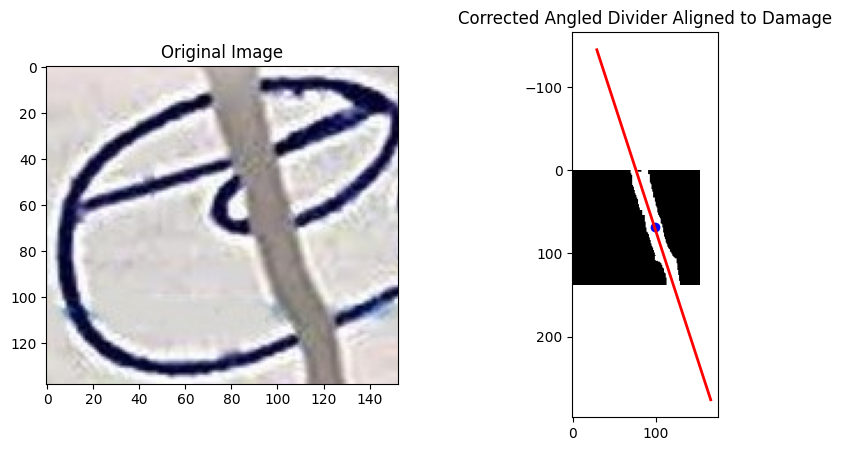

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.morphology import skeletonize

# Function to Convert RGB to HSI and Extract Intensity
def rgb_to_hsi(image):
    img = image.astype(np.float32) / 255.0
    B, G, R = cv2.split(img)
    I = (R + G + B) / 3  # Intensity
    return (I * 255).astype(np.uint8)

# Function to Detect Damage and Extract Oriented Divider
def extract_text_and_background(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply Gaussian Blur to Reduce Noise
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Convert to HSI and Extract Intensity
    I = rgb_to_hsi(img_blur)

    # K-Means Clustering for Damage Detection
    pixels = I.reshape(-1, 1)
    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(pixels)
    clustered = kmeans.labels_.reshape(I.shape)

    # Identify Clusters
    cluster_means = [np.mean(pixels[kmeans.labels_ == i]) for i in range(3)]
    sorted_clusters = np.argsort(cluster_means)

    text_cluster = sorted_clusters[0]
    hole_cluster = sorted_clusters[1]
    background_cluster = sorted_clusters[2]

    # Damage Mask
    hole_mask = (clustered == hole_cluster).astype(np.uint8) * 255

    # Apply Morphological Opening (Remove Small Noise)
    kernel = np.ones((3, 3), np.uint8)
    hole_mask_cleaned = cv2.morphologyEx(hole_mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find Damage Contours
    contours, _ = cv2.findContours(hole_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return hole_mask, None, None, None, None

    # Get the Largest Damage Cluster
    largest_contour = max(contours, key=cv2.contourArea)

    # Fit a Rotated Bounding Box
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Extract the Center
    (cx, cy), (w, h), _ = rect

    # **Fix: Compute Damage Orientation Using cv2.fitLine()**
    [vx, vy, x0, y0] = cv2.fitLine(largest_contour, cv2.DIST_L2, 0, 0.01, 0.01)

    # Compute Start and End Points of Divider Along This Angle
    length = max(w, h) * 1.5  # Extend line beyond damage area
    divider_start = (int(x0 - length * vx), int(y0 - length * vy))
    divider_end = (int(x0 + length * vx), int(y0 + length * vy))

    # Show Damage and Divider Line
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(hole_mask_cleaned, cmap='gray')
    plt.plot([divider_start[0], divider_end[0]], [divider_start[1], divider_end[1]], 'r-', linewidth=2)
    plt.scatter(cx, cy, c='blue', marker='o')  # Show centroid
    plt.title("Corrected Angled Divider Aligned to Damage")
    plt.show()

    return hole_mask_cleaned, (cx, cy), (divider_start, divider_end)

# Load Image and Detect Damage
image_path = "/content/minorSeg.jpeg"
hole_mask, center, divider = extract_text_and_background(image_path)


<ipython-input-33-30c4ab95c104>:57: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
<ipython-input-33-30c4ab95c104>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  divider_start = (int(x0 - length * vx), int(y0 - length * vy))
<ipython-input-33-30c4ab95c104>:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  divider_end = (int(x0 + length * vx), int(y0 + length * vy))


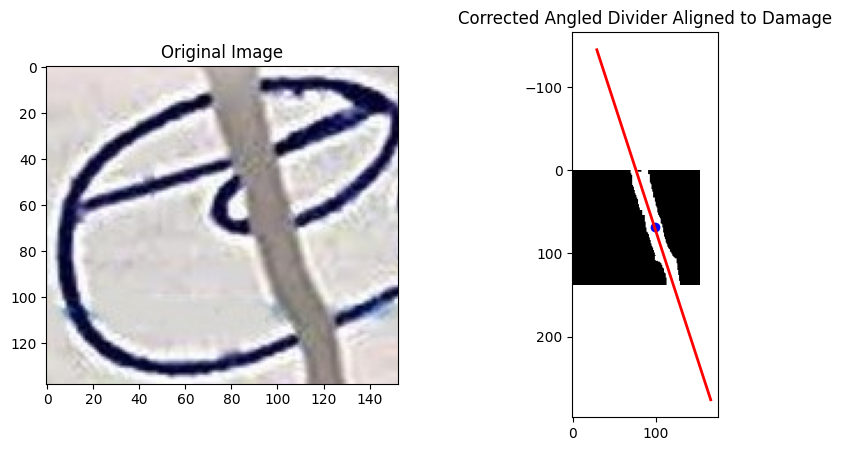

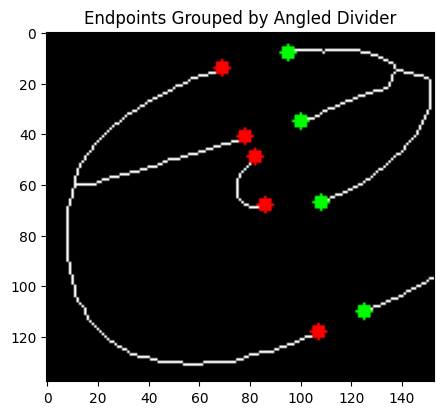

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.morphology import skeletonize

# Function to Detect Endpoints
def detect_endpoints(skeleton):
    endpoints = []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 255:
                neighbors = [
                    skeleton[y-1, x-1], skeleton[y-1, x], skeleton[y-1, x+1],
                    skeleton[y, x-1],                     skeleton[y, x+1],
                    skeleton[y+1, x-1], skeleton[y+1, x], skeleton[y+1, x+1]
                ]
                if np.sum(neighbors) == 255:
                    endpoints.append((x, y))
    return endpoints

# Function to Group Endpoints Based on the Divider
def group_endpoints_by_divider(endpoints, divider_start, divider_end):
    """
    Groups endpoints into two sides based on their position relative to the divider.
    """
    side_1 = []
    side_2 = []

    # Line Equation: ax + by + c = 0
    x1, y1 = divider_start
    x2, y2 = divider_end
    a = y2 - y1
    b = x1 - x2
    c = x2 * y1 - x1 * y2

    for x, y in endpoints:
        # Compute distance from the point to the divider line
        d = a * x + b * y + c

        if d < 0:
            side_1.append((x, y))  # One side
        else:
            side_2.append((x, y))  # Other side

    return side_1, side_2

# Load Image and Detect Damage Divider
image_path = "/content/minorSeg.jpeg"
hole_mask, center, divider = extract_text_and_background(image_path)

# Load Processed Image
cleaned_img = cv2.imread("/content/text_background_filtered.png", cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(cleaned_img, 128, 255, cv2.THRESH_BINARY_INV)

# Apply Skeletonization
skeleton = skeletonize(binary // 255) * 255

# Detect Endpoints
endpoints = detect_endpoints(skeleton)

# Group Endpoints Based on Angled Divider
group1, group2 = group_endpoints_by_divider(endpoints, divider[0], divider[1])

# **Step 3: Show Grouped Endpoints**
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)
for x, y in group1:
    cv2.circle(skeleton_colored, (x, y), 3, (255, 0, 0), -1)  # Red for one side
for x, y in group2:
    cv2.circle(skeleton_colored, (x, y), 3, (0, 255, 0), -1)  # Green for other side

plt.figure(figsize=(5, 5))
plt.imshow(skeleton_colored)
plt.title("Endpoints Grouped by Angled Divider")
plt.show()


<ipython-input-33-30c4ab95c104>:57: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
<ipython-input-33-30c4ab95c104>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  divider_start = (int(x0 - length * vx), int(y0 - length * vy))
<ipython-input-33-30c4ab95c104>:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  divider_end = (int(x0 + length * vx), int(y0 + length * vy))


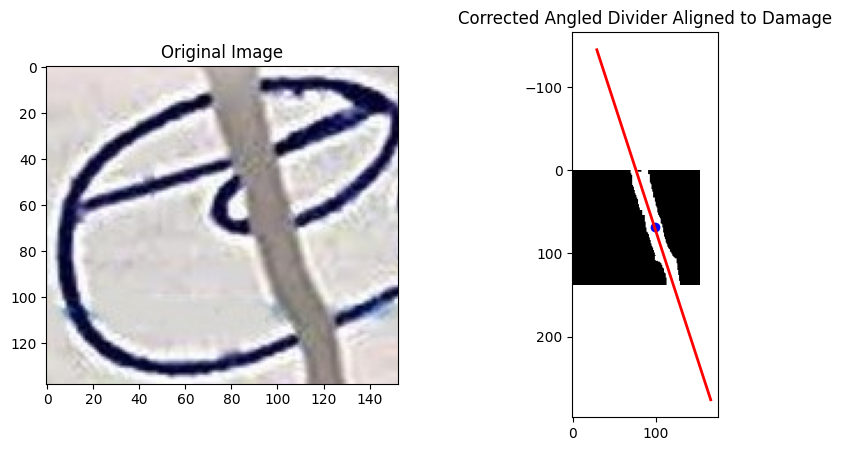

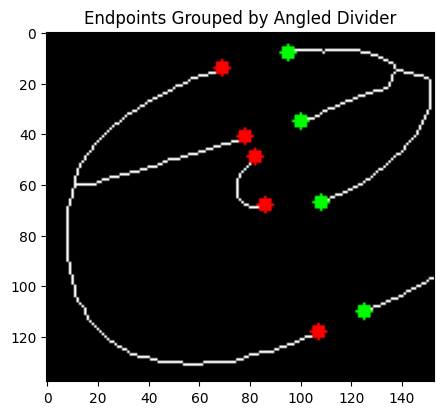

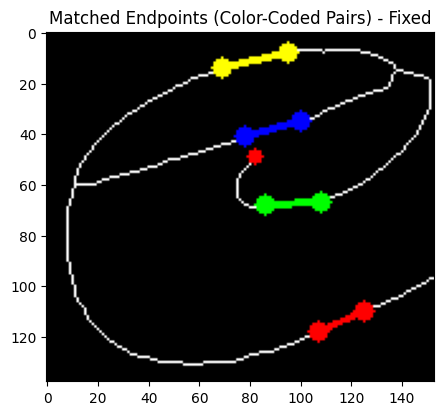

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy.spatial.distance import cdist

# Function to Detect Endpoints
def detect_endpoints(skeleton):
    endpoints = []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x] == 255:
                neighbors = [
                    skeleton[y-1, x-1], skeleton[y-1, x], skeleton[y-1, x+1],
                    skeleton[y, x-1],                     skeleton[y, x+1],
                    skeleton[y+1, x-1], skeleton[y+1, x], skeleton[y+1, x+1]
                ]
                if np.sum(neighbors) == 255:
                    endpoints.append((x, y))
    return endpoints

# Function to Group Endpoints Based on Divider
def group_endpoints_by_divider(endpoints, divider_start, divider_end):
    side_1, side_2 = [], []

    x1, y1 = divider_start
    x2, y2 = divider_end
    a = y2 - y1
    b = x1 - x2
    c = x2 * y1 - x1 * y2

    for x, y in endpoints:
        d = a * x + b * y + c
        if d < 0:
            side_1.append((x, y))  # One side
        else:
            side_2.append((x, y))  # Other side

    return side_1, side_2

# Function to Match Endpoints (Strict One-to-One First, Then Handle Orphans)
def match_endpoints(group1, group2):
    matched_pairs = []
    orphaned_group1 = set(range(len(group1)))
    orphaned_group2 = set(range(len(group2)))

    if not group1 or not group2:
        return matched_pairs

    # Compute Pairwise Distances
    group1_arr = np.array(group1)
    group2_arr = np.array(group2)
    distances = cdist(group1_arr, group2_arr)  # Compute all distances

    # **Step 1: Strict One-to-One Matching**
    while np.any(distances != np.inf):  # Ensure there are valid matches left
        min_idx = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        g1_idx, g2_idx = min_idx

        if g1_idx in orphaned_group1 and g2_idx in orphaned_group2:
            matched_pairs.append((group1[g1_idx], group2[g2_idx]))
            orphaned_group1.remove(g1_idx)
            orphaned_group2.remove(g2_idx)

        # Mark matched points as used
        distances[g1_idx, :] = np.inf
        distances[:, g2_idx] = np.inf

    # **Step 2: Allow Extra Matches Only for Orphaned Endpoints**
    for g1_idx in list(orphaned_group1):
        g1_pt = group1[g1_idx]

        # Find Closest Two Unmatched Endpoints from Group 2
        dists = np.linalg.norm(group2_arr - g1_pt, axis=1)
        closest_idx = np.argsort(dists)[:2]  # Pick two closest

        for i in closest_idx:
            if i in orphaned_group2:  # Only allow if still unmatched
                matched_pairs.append((g1_pt, group2[i]))
                orphaned_group2.remove(i)

    return matched_pairs

# Load Image and Detect Damage Divider
image_path = "/content/minorSeg.jpeg"
hole_mask, center, divider = extract_text_and_background(image_path)

# Load Processed Image
cleaned_img = cv2.imread("/content/text_background_filtered.png", cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(cleaned_img, 128, 255, cv2.THRESH_BINARY_INV)

# Apply Skeletonization
skeleton = skeletonize(binary // 255) * 255

# Detect Endpoints
endpoints = detect_endpoints(skeleton)

# Group Endpoints Based on Angled Divider
group1, group2 = group_endpoints_by_divider(endpoints, divider[0], divider[1])

# **Step 3: Show Grouped Endpoints**
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)
for x, y in group1:
    cv2.circle(skeleton_colored, (x, y), 3, (255, 0, 0), -1)  # Red for one side
for x, y in group2:
    cv2.circle(skeleton_colored, (x, y), 3, (0, 255, 0), -1)  # Green for other side

plt.figure(figsize=(5, 5))
plt.imshow(skeleton_colored)
plt.title("Endpoints Grouped by Angled Divider")
plt.show()

# **Step 4: Match Endpoints**
matched_pairs = match_endpoints(group1, group2)

# **Step 5: Show Matched Pairs in Unique Colors**
color_palette = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255),
    (255, 255, 0), (255, 0, 255), (0, 255, 255),
    (128, 0, 0), (0, 128, 0), (0, 0, 128),
]
color_index = 0

for (x1, y1), (x2, y2) in matched_pairs:
    color = color_palette[color_index % len(color_palette)]
    cv2.line(skeleton_colored, (x1, y1), (x2, y2), color, 2)
    cv2.circle(skeleton_colored, (x1, y1), 4, color, -1)
    cv2.circle(skeleton_colored, (x2, y2), 4, color, -1)
    color_index += 1  # Move to next color

plt.figure(figsize=(5, 5))
plt.imshow(skeleton_colored)
plt.title("Matched Endpoints (Color-Coded Pairs) - Fixed")
plt.show()


<ipython-input-33-30c4ab95c104>:57: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
<ipython-input-33-30c4ab95c104>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  divider_start = (int(x0 - length * vx), int(y0 - length * vy))
<ipython-input-33-30c4ab95c104>:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  divider_end = (int(x0 + length * vx), int(y0 + length * vy))


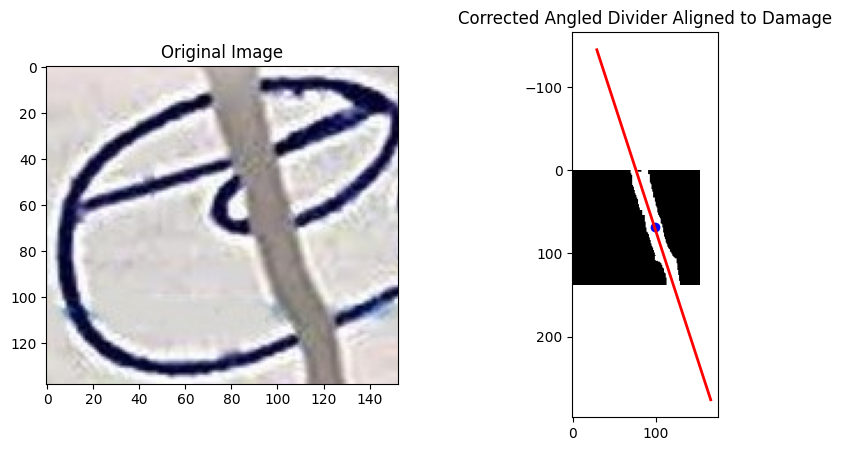

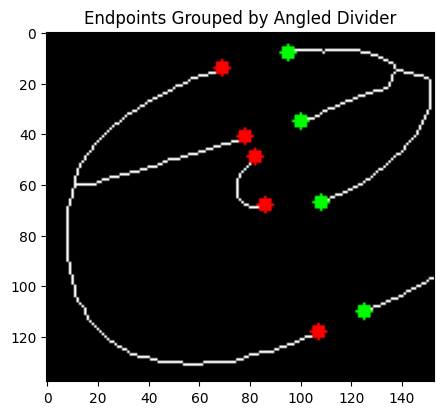

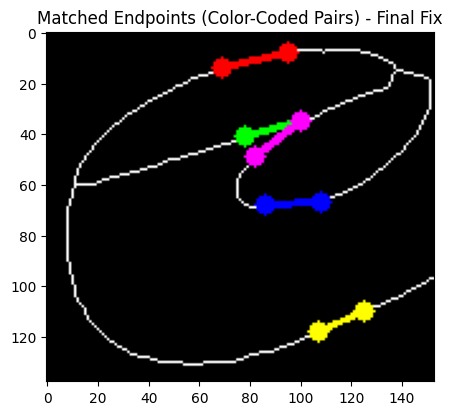

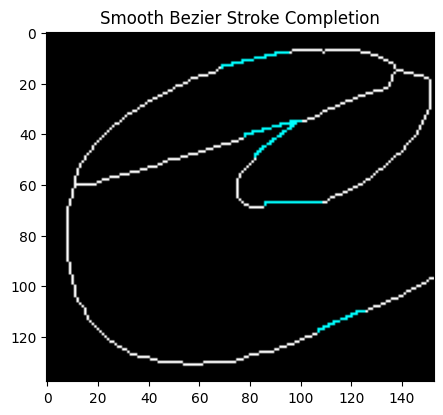

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy.interpolate import splprep, splev


# Function to compute gradient direction (Stroke orientation)
def compute_gradient_direction(binary_image):
    binary_image = (binary_image * 255).astype(np.uint8)  # Ensure correct format
    blurred = cv2.GaussianBlur(binary_image, (3, 3), 0)

    # Compute Sobel gradients
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal gradient
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)  # Vertical gradient

    return np.arctan2(sobely, sobelx)


# Function to Match Endpoints (Step-by-Step Strategy)
def match_endpoints(group1, group2, max_distance_step=10, max_angle_step=5):
    matched_pairs = []

    # Step 1: Identify the Smaller and Larger Groups
    if len(group1) <= len(group2):
        smaller_group, larger_group = group1, group2
    else:
        smaller_group, larger_group = group2, group1

    orphaned_endpoints = set(range(len(larger_group)))

    # Step 2: Match for Smaller Group First
    smaller_arr = np.array(smaller_group)
    larger_arr = np.array(larger_group)
    distances = cdist(smaller_arr, larger_arr)

    assigned_larger = set()

    for i, small_endpoint in enumerate(smaller_group):
        min_dist = np.inf
        best_match = None

        # **Try Matching Within Increasing Distance and Angle Steps**
        for dist_limit in range(10, 101, max_distance_step):  # Increase step-by-step
            for angle_limit in range(5, 46, max_angle_step):  # Angle flexibility
                # Compute distances
                dists = np.linalg.norm(larger_arr - small_endpoint, axis=1)
                valid_indices = np.where((dists <= dist_limit))[0]  # Get valid points

                if valid_indices.size > 0:
                    # Find closest match
                    match_idx = valid_indices[np.argmin(dists[valid_indices])]
                    if match_idx not in assigned_larger:
                        best_match = match_idx
                        assigned_larger.add(match_idx)
                        orphaned_endpoints.discard(match_idx)
                        break  # Stop once we find the closest
            if best_match is not None:
                break

        if best_match is not None:
            matched_pairs.append((small_endpoint, larger_group[best_match]))

    # Step 3: Match Remaining Orphaned Endpoints
    for orphan_idx in orphaned_endpoints:
        orphan_point = larger_group[orphan_idx]

        min_dist = np.inf
        best_match = None

        for dist_limit in range(10, 151, max_distance_step):
            for angle_limit in range(5, 46, max_angle_step):
                dists = np.linalg.norm(smaller_arr - orphan_point, axis=1)
                valid_indices = np.where((dists <= dist_limit))[0]

                if valid_indices.size > 0:
                    match_idx = valid_indices[np.argmin(dists[valid_indices])]
                    best_match = match_idx
                    break
            if best_match is not None:
                break

        if best_match is not None:
            matched_pairs.append((orphan_point, smaller_group[best_match]))

    return matched_pairs

# Load Image and Detect Damage Divider
image_path = "/content/minorSeg.jpeg"
hole_mask, center, divider = extract_text_and_background(image_path)

# Load Processed Image
cleaned_img = cv2.imread("/content/text_background_filtered.png", cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(cleaned_img, 128, 255, cv2.THRESH_BINARY_INV)

# Apply Skeletonization
skeleton = skeletonize(binary // 255) * 255

# Detect Endpoints
endpoints = detect_endpoints(skeleton)

# Group Endpoints Based on Angled Divider
group1, group2 = group_endpoints_by_divider(endpoints, divider[0], divider[1])

# **Step 3: Show Grouped Endpoints**
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)
for x, y in group1:
    cv2.circle(skeleton_colored, (x, y), 3, (255, 0, 0), -1)  # Red for one side
for x, y in group2:
    cv2.circle(skeleton_colored, (x, y), 3, (0, 255, 0), -1)  # Green for other side

plt.figure(figsize=(5, 5))
plt.imshow(skeleton_colored)
plt.title("Endpoints Grouped by Angled Divider")
plt.show()

# **Step 4: Match Endpoints**
matched_pairs = match_endpoints(group1, group2)

# **Step 5: Show Matched Pairs in Unique Colors**
color_palette = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255),
    (255, 255, 0), (255, 0, 255), (0, 255, 255),
    (128, 0, 0), (0, 128, 0), (0, 0, 128),
]
color_index = 0

for (x1, y1), (x2, y2) in matched_pairs:
    color = color_palette[color_index % len(color_palette)]
    cv2.line(skeleton_colored, (x1, y1), (x2, y2), color, 2)
    cv2.circle(skeleton_colored, (x1, y1), 4, color, -1)
    cv2.circle(skeleton_colored, (x2, y2), 4, color, -1)
    color_index += 1  # Move to next color

# **Step 6: Show Final Matched Pairs**
gradient_map = compute_gradient_direction(skeleton)
plt.figure(figsize=(5, 5))
plt.imshow(skeleton_colored)
plt.title("Matched Endpoints (Color-Coded Pairs) - Final Fix")
plt.show()

def bezier_curve(p1, p2, control1, control2, num_points=100):
    """
    Generates a cubic Bezier curve between two endpoints.
    - p1, p2: Endpoints of the curve.
    - control1, control2: Control points for Bezier shaping.
    - num_points: Number of points in the curve.
    """
    t = np.linspace(0, 1, num_points)
    bezier_x = (1 - t) ** 3 * p1[0] + 3 * (1 - t) ** 2 * t * control1[0] + 3 * (1 - t) * t ** 2 * control2[0] + t ** 3 * p2[0]
    bezier_y = (1 - t) ** 3 * p1[1] + 3 * (1 - t) ** 2 * t * control1[1] + 3 * (1 - t) * t ** 2 * control2[1] + t ** 3 * p2[1]
    return bezier_x, bezier_y

def fit_bezier_curve(p1, p2, gradient_map, curvature_scale=20):
    """
    Fits a smooth cubic Bezier curve using stroke gradients for control points.
    """
    p1, p2 = np.array(p1), np.array(p2)

    # Compute gradient direction at endpoints
    grad_p1 = gradient_map[p1[1], p1[0]]
    grad_p2 = gradient_map[p2[1], p2[0]]

    # Control points are placed along the gradient direction
    control1 = p1 + curvature_scale * np.array([grad_p1, -grad_p1])
    control2 = p2 + curvature_scale * np.array([grad_p2, -grad_p2])

    return bezier_curve(p1, p2, control1, control2)

# **Step 1: Visualize Smooth Bezier Stroke Completion**
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)

plt.figure(figsize=(5, 5))
plt.imshow(skeleton_colored)
plt.title("Smooth Bezier Stroke Completion")

for (p1, p2) in matched_pairs:
    bezier_x, bezier_y = fit_bezier_curve(p1, p2, gradient_map)

    # Draw final smooth curve
    for i in range(len(bezier_x) - 1):
        cv2.line(skeleton_colored, (int(bezier_x[i]), int(bezier_y[i])),
                 (int(bezier_x[i+1]), int(bezier_y[i+1])),
                 (0, 255, 255), 1)  # Yellow for completed strokes

plt.imshow(skeleton_colored)
plt.show()

<ipython-input-33-30c4ab95c104>:57: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
<ipython-input-33-30c4ab95c104>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  divider_start = (int(x0 - length * vx), int(y0 - length * vy))
<ipython-input-33-30c4ab95c104>:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  divider_end = (int(x0 + length * vx), int(y0 + length * vy))


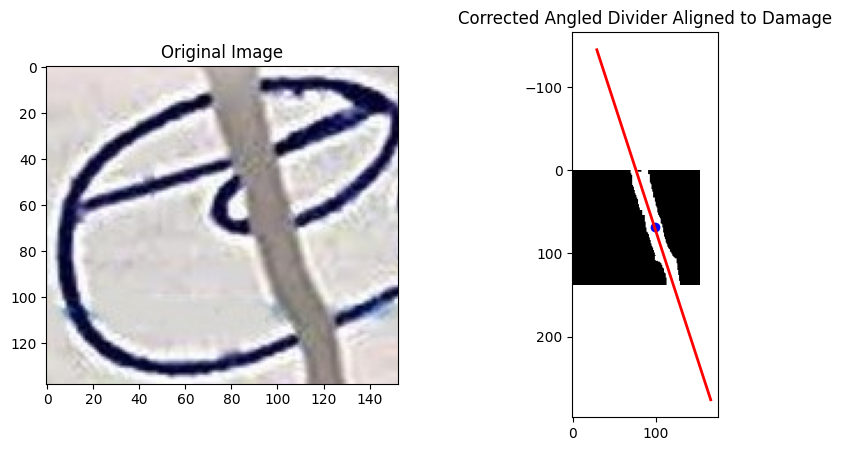

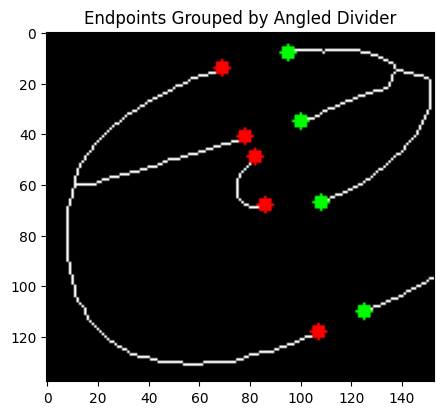

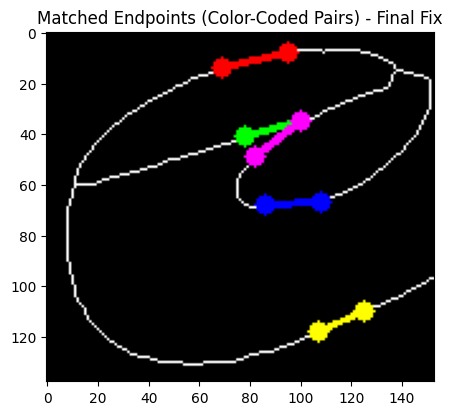

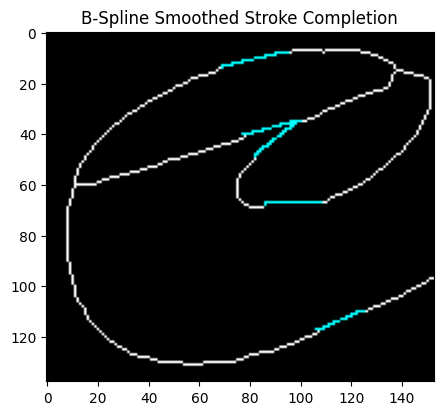

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy.interpolate import splprep, splev
from scipy.ndimage import gaussian_filter1d

# Function to Match Endpoints (Step-by-Step Strategy)
def match_endpoints(group1, group2, max_distance_step=10, max_angle_step=5):
    matched_pairs = []

    # Step 1: Identify the Smaller and Larger Groups
    if len(group1) <= len(group2):
        smaller_group, larger_group = group1, group2
    else:
        smaller_group, larger_group = group2, group1

    orphaned_endpoints = set(range(len(larger_group)))

    # Step 2: Match for Smaller Group First
    smaller_arr = np.array(smaller_group)
    larger_arr = np.array(larger_group)
    distances = cdist(smaller_arr, larger_arr)

    assigned_larger = set()

    for i, small_endpoint in enumerate(smaller_group):
        min_dist = np.inf
        best_match = None

        # **Try Matching Within Increasing Distance and Angle Steps**
        for dist_limit in range(10, 101, max_distance_step):  # Increase step-by-step
            for angle_limit in range(5, 46, max_angle_step):  # Angle flexibility
                # Compute distances
                dists = np.linalg.norm(larger_arr - small_endpoint, axis=1)
                valid_indices = np.where((dists <= dist_limit))[0]  # Get valid points

                if valid_indices.size > 0:
                    # Find closest match
                    match_idx = valid_indices[np.argmin(dists[valid_indices])]
                    if match_idx not in assigned_larger:
                        best_match = match_idx
                        assigned_larger.add(match_idx)
                        orphaned_endpoints.discard(match_idx)
                        break  # Stop once we find the closest
            if best_match is not None:
                break

        if best_match is not None:
            matched_pairs.append((small_endpoint, larger_group[best_match]))

    # Step 3: Match Remaining Orphaned Endpoints
    for orphan_idx in orphaned_endpoints:
        orphan_point = larger_group[orphan_idx]

        min_dist = np.inf
        best_match = None

        for dist_limit in range(10, 151, max_distance_step):
            for angle_limit in range(5, 46, max_angle_step):
                dists = np.linalg.norm(smaller_arr - orphan_point, axis=1)
                valid_indices = np.where((dists <= dist_limit))[0]

                if valid_indices.size > 0:
                    match_idx = valid_indices[np.argmin(dists[valid_indices])]
                    best_match = match_idx
                    break
            if best_match is not None:
                break

        if best_match is not None:
            matched_pairs.append((orphan_point, smaller_group[best_match]))

    return matched_pairs

# Load Image and Detect Damage Divider
image_path = "/content/minorSeg.jpeg"
hole_mask, center, divider = extract_text_and_background(image_path)

# Load Processed Image
cleaned_img = cv2.imread("/content/text_background_filtered.png", cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(cleaned_img, 128, 255, cv2.THRESH_BINARY_INV)

# Apply Skeletonization
skeleton = skeletonize(binary // 255) * 255

# Detect Endpoints
endpoints = detect_endpoints(skeleton)

# Group Endpoints Based on Angled Divider
group1, group2 = group_endpoints_by_divider(endpoints, divider[0], divider[1])

# **Step 3: Show Grouped Endpoints**
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)
for x, y in group1:
    cv2.circle(skeleton_colored, (x, y), 3, (255, 0, 0), -1)  # Red for one side
for x, y in group2:
    cv2.circle(skeleton_colored, (x, y), 3, (0, 255, 0), -1)  # Green for other side

plt.figure(figsize=(5, 5))
plt.imshow(skeleton_colored)
plt.title("Endpoints Grouped by Angled Divider")
plt.show()

# **Step 4: Match Endpoints**
matched_pairs = match_endpoints(group1, group2)

# **Step 5: Show Matched Pairs in Unique Colors**
color_palette = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255),
    (255, 255, 0), (255, 0, 255), (0, 255, 255),
    (128, 0, 0), (0, 128, 0), (0, 0, 128),
]
color_index = 0

for (x1, y1), (x2, y2) in matched_pairs:
    color = color_palette[color_index % len(color_palette)]
    cv2.line(skeleton_colored, (x1, y1), (x2, y2), color, 2)
    cv2.circle(skeleton_colored, (x1, y1), 4, color, -1)
    cv2.circle(skeleton_colored, (x2, y2), 4, color, -1)
    color_index += 1  # Move to next color

# **Step 6: Show Final Matched Pairs**
plt.figure(figsize=(5, 5))
plt.imshow(skeleton_colored)
plt.title("Matched Endpoints (Color-Coded Pairs) - Final Fix")
plt.show()

def bezier_curve(p1, p2, control1, control2, num_points=300):
    """ Generates a high-resolution cubic Bezier curve. """
    t = np.linspace(0, 1, num_points)
    bezier_x = (1 - t) ** 3 * p1[0] + 3 * (1 - t) ** 2 * t * control1[0] + 3 * (1 - t) * t ** 2 * control2[0] + t ** 3 * p2[0]
    bezier_y = (1 - t) ** 3 * p1[1] + 3 * (1 - t) ** 2 * t * control1[1] + 3 * (1 - t) * t ** 2 * control2[1] + t ** 3 * p2[1]
    return bezier_x, bezier_y

def smooth_curve(x_vals, y_vals, smoothing_factor=5):
    """ Applies B-Spline smoothing to a given curve. """
    tck, u = splprep([x_vals, y_vals], s=smoothing_factor)
    smooth_x, smooth_y = splev(np.linspace(0, 1, len(x_vals)), tck)
    return smooth_x, smooth_y

def fit_smooth_bezier_curve(p1, p2, gradient_map, curvature_scale=20):
    """ Generates a smooth Bezier curve with B-Spline refinement. """
    p1, p2 = np.array(p1), np.array(p2)

    # Estimate stroke gradient
    grad_p1 = gradient_map[p1[1], p1[0]]
    grad_p2 = gradient_map[p2[1], p2[0]]

    # Compute control points along gradient direction
    control1 = p1 + curvature_scale * np.array([grad_p1, -grad_p1])
    control2 = p2 + curvature_scale * np.array([grad_p2, -grad_p2])

    # Generate initial Bezier curve
    bezier_x, bezier_y = bezier_curve(p1, p2, control1, control2)

    # Apply B-Spline smoothing
    smooth_x, smooth_y = smooth_curve(bezier_x, bezier_y)

    return smooth_x, smooth_y

# **Step 1: Visualize Smoothed Stroke Completion**
skeleton_colored = cv2.cvtColor(skeleton.astype(np.uint8), cv2.COLOR_GRAY2BGR)

plt.figure(figsize=(5, 5))
plt.imshow(skeleton_colored)
plt.title("B-Spline Smoothed Stroke Completion")

for (p1, p2) in matched_pairs:
    smooth_x, smooth_y = fit_smooth_bezier_curve(p1, p2, gradient_map)

    # Draw smoothed curve
    for i in range(len(smooth_x) - 1):
        cv2.line(skeleton_colored, (int(smooth_x[i]), int(smooth_y[i])),
                 (int(smooth_x[i+1]), int(smooth_y[i+1])),
                 (0, 255, 255), 1)  # Yellow for completed strokes

plt.imshow(skeleton_colored)
plt.show()

